In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import xgboost as xgb

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [13]:
print train.shape, test.shape

(891, 12) (418, 11)


In [14]:
Y_train = train.Survived
test_id = test.PassengerId

In [15]:
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)
print 'shape: '
print train_test.shape, train.shape, test.shape
print '~~~~~~~~~~~~~'
print 'type'
print train_test.dtypes
print '~~~~~~~~~~~~~'
print 'No. of Nans'
print train_test.isnull().sum()
print '~~~~~~~~~~~~~'
train_test.head(2)

shape: 
(1309, 7) (891, 12) (418, 11)
~~~~~~~~~~~~~
type
Age         float64
Embarked     object
Fare        float64
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
dtype: object
~~~~~~~~~~~~~
No. of Nans
Age         263
Embarked      2
Fare          1
Parch         0
Pclass        0
Sex           0
SibSp         0
dtype: int64
~~~~~~~~~~~~~


Age Embarked     Fare  Parch  Pclass     Sex  SibSp
0  22.0        S   7.2500      0       3    male      1
1  38.0        C  71.2833      0       1  female      1

In [16]:
print 'fill NaNs with mean or mode for object type'
train['Age'].fillna((train['Age'].mean()), inplace=True)
train['Fare'].fillna((train['Fare'].mean()), inplace=True)
train['Embarked'].fillna((train.Embarked.value_counts()[0]), inplace=True)
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna((test['Fare'].mean()), inplace=True)
test['Embarked'].fillna((test.Embarked.value_counts()[0]), inplace=True)
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)

print 'No. of Nans'
print train_test.isnull().sum()
train_test.head(2)

fill NaNs with mean or mode for object type
No. of Nans
Age         0
Embarked    0
Fare        0
Parch       0
Pclass      0
Sex         0
SibSp       0
dtype: int64


Age Embarked     Fare  Parch  Pclass     Sex  SibSp
0  22.0        S   7.2500      0       3    male      1
1  38.0        C  71.2833      0       1  female      1

In [17]:
print 'process object types: ["Embarked", "Sex"]'
train_test['Embarked'] = train_test['Embarked'].factorize()[0]
train_test = pd.concat([train_test, pd.get_dummies(train_test.Sex)], axis = 1)
train_test = train_test.drop(['Sex'], axis = 1)
print train_test.dtypes
train_test.head()

process object types: ["Embarked", "Sex"]
Age         float64
Embarked      int64
Fare        float64
Parch         int64
Pclass        int64
SibSp         int64
female        uint8
male          uint8
dtype: object


Age  Embarked     Fare  Parch  Pclass  SibSp  female  male
0  22.0         0   7.2500      0       3      1       0     1
1  38.0         1  71.2833      0       1      1       1     0
2  26.0         0   7.9250      0       3      0       1     0
3  35.0         0  53.1000      0       1      1       1     0
4  35.0         0   8.0500      0       3      0       0     1

In [18]:
train_test.describe()

Age     Embarked         Fare        Parch       Pclass  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.882243     0.398778    33.297261     0.385027     2.294882   
std      12.883758     0.661200    51.738919     0.865560     0.837836   
min       0.170000     0.000000     0.000000     0.000000     1.000000   
25%      22.000000     0.000000     7.895800     0.000000     2.000000   
50%      29.699118     0.000000    14.454200     0.000000     3.000000   
75%      35.000000     1.000000    31.275000     0.000000     3.000000   
max      80.000000     3.000000   512.329200     9.000000     3.000000   

             SibSp       female         male  
count  1309.000000  1309.000000  1309.000000  
mean      0.498854     0.355997     0.644003  
std       1.041658     0.478997     0.478997  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     1.000000  
75%       1.000000     1.000000     1.000000  
max       8.000000     1.000000     1.000000

In [19]:
def normalize(columns):
    for col in columns:
        mu = train[col].mean()
        sigma = train[col].std()
        train_test[col] = (train[col] - train[col].mean())/train[col].std()

In [20]:
print 'normalize columns ["Age", "Fare"]: '
columns_to_normalize = ['Age', 'Fare']
normalize(columns_to_normalize)
train_test.describe()

normalize columns ["Age", "Fare"]: 


Age     Embarked         Fare        Parch       Pclass  \
count  1.309000e+03  1309.000000  1309.000000  1309.000000  1309.000000   
mean  -2.006238e-02     0.398778     0.002039     0.385027     2.294882   
std    9.919921e-01     0.661200     0.997283     0.865560     0.837836   
min   -2.251891e+00     0.000000    -0.648058     0.000000     1.000000   
25%   -5.921480e-01     0.000000    -0.488580     0.000000     2.000000   
50%    4.371893e-15     0.000000    -0.357190     0.000000     3.000000   
75%    4.076970e-01     1.000000    -0.024233     0.000000     3.000000   
max    3.868699e+00     3.000000     9.661740     9.000000     3.000000   

             SibSp       female         male  
count  1309.000000  1309.000000  1309.000000  
mean      0.498854     0.355997     0.644003  
std       1.041658     0.478997     0.478997  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     1.000000  
75%       1.000000     1.000000     1.000000  
max       8.000000     1.000000     1.000000

In [21]:
X_train = train_test[:len(train)]
X_test = train_test[len(train):]
print X_train.shape, X_test.shape

(891, 8) (418, 8)


In [ ]:
print X_train.shape, Y_train.shape
X_train, X_cv, Y_train, Y_cv = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.3)
print X_train.shape, Y_train.shape
print X_cv.shape, Y_cv.shape

# Logistic regression

In [1652]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1+np.exp(-x))

In [1653]:
def logistic_regression_cost_and_gradient(X_train, Y_train, theta, la):
    # return cost J and gradient of theta in grad
    m = len(Y_train)
    X = X_train.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    Y = np.array(Y_train)
    h_theta = sigmoid(np.dot(X, theta))
    J = -(np.dot(Y, np.log(h_theta)) + np.dot(1-Y, np.log(1-h_theta))) / m + np.dot(theta[1:], theta[1:])*la / (2*m)
    grad = np.dot(X.transpose(), h_theta - Y) / m + theta*la / m
    grad[0] = grad[0] - theta[0]*la / m     
    return [J, grad]

In [1654]:
def logistic_regression_model(X_train, Y_train, theta, la, alpha=0.1, epsilon = 10.0**(-6), max_iterators = 5000):
    # return cost J and optimal theta 
    [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
    cost = [J]
    for i in range(max_iterators):
        theta = theta - alpha * grad
        [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
        if abs(cost[-1] - J) < epsilon:
            break
        cost.append(J)
        
    plt.plot(cost)
    plt.title('alpha = %r, lambda = %r'% (alpha, la))
    plt.xlabel('No. of iterations')
    plt.ylabel('Cost function J')
    plt.show()
    
    return [J, theta]

In [1656]:
def logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas):
    init_theta = np.zeros(X_train.shape[1] + 1)
    J_train = len(lambdas)*[0]
    J_cv = len(lambdas)*[0]
    thetas = []
    for i in range(len(lambdas)):
        [J, theta] = logistic_regression_model(X_train, Y_train, init_theta, lambdas[i])
        [J_train[i], grad_train] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, 0)
        [J_cv[i], grad_cv] = logistic_regression_cost_and_gradient(X_cv, Y_cv, theta, 0)
        thetas.append(theta)
    idx = J_cv.index(min(J_cv))
    lambda_best = lambdas[idx]
    theta_best = thetas[idx]
    
    plot_train, = plt.plot(lambdas, J_train, label='J_train')
    plot_cv, = plt.plot(lambdas, J_cv, label='J_cv')
    plt.title('Cross Validation')
    plt.xlabel('lambda')
    plt.ylabel('Cost function J')
    plt.legend([plot_train, plot_cv], ["J_train", "J_cv"])
    plt.show()
    
    return [lambda_best, theta_best]

look for best parameters:


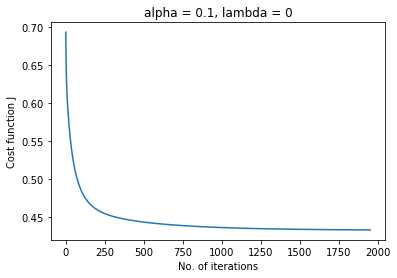

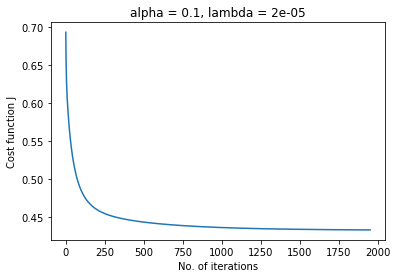

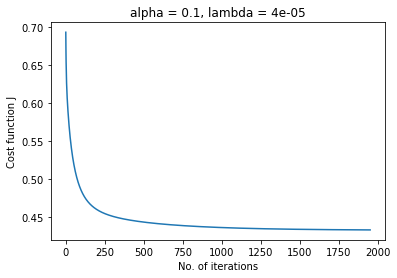

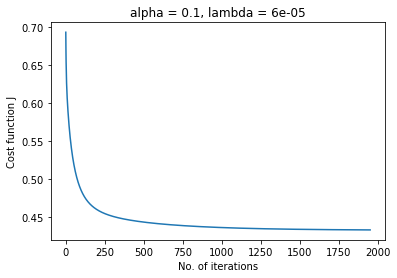

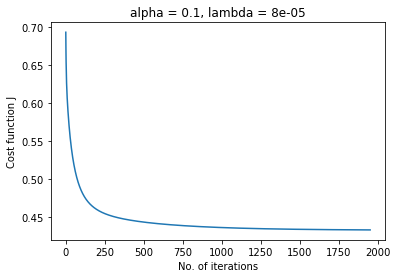

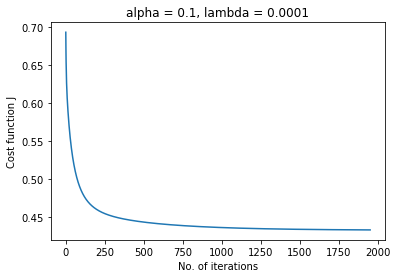

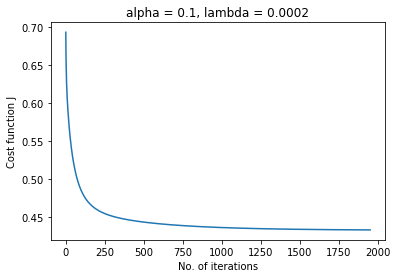

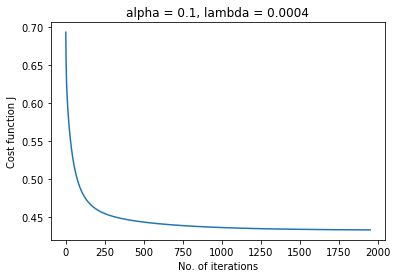

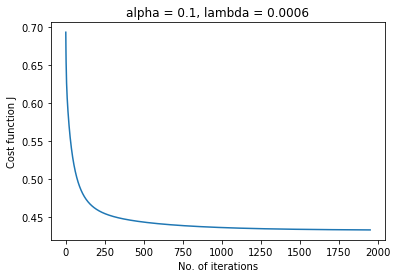

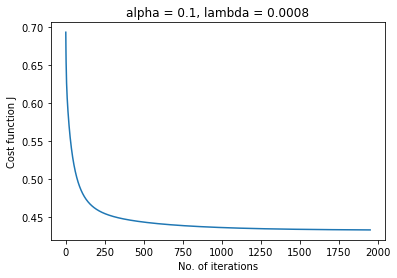

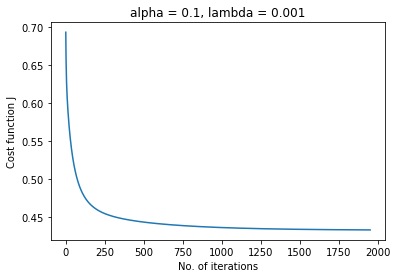

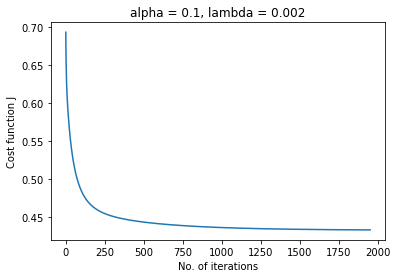

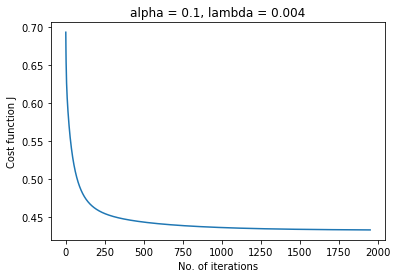

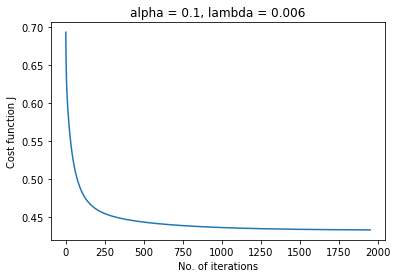

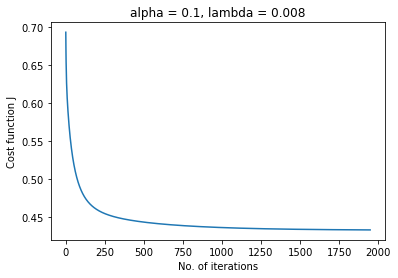

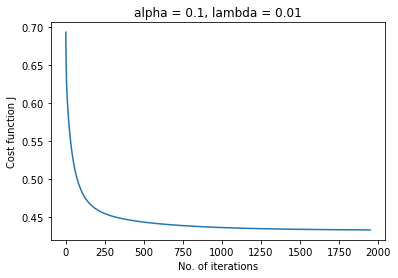

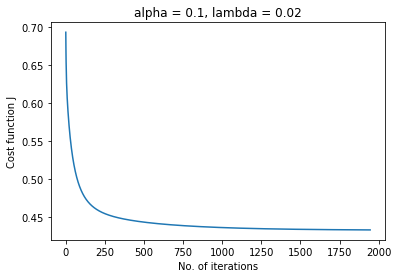

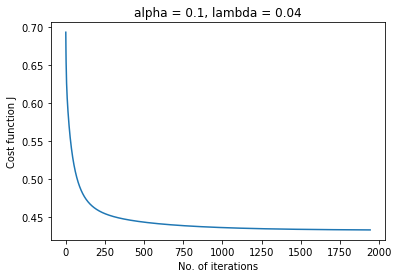

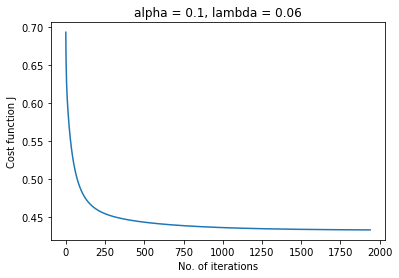

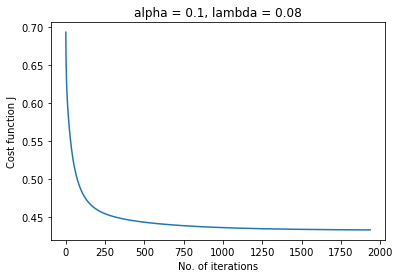

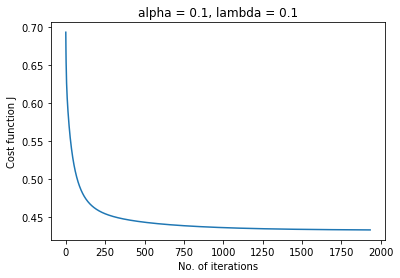

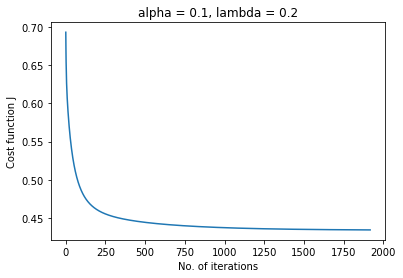

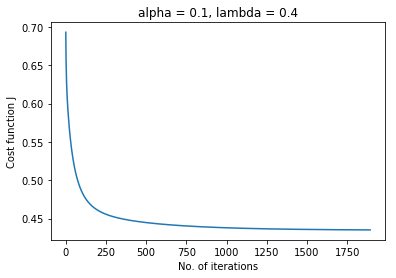

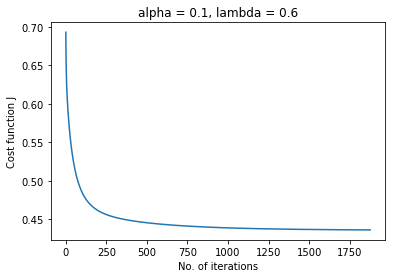

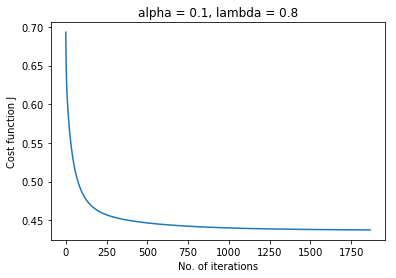

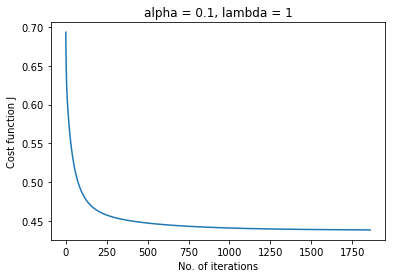

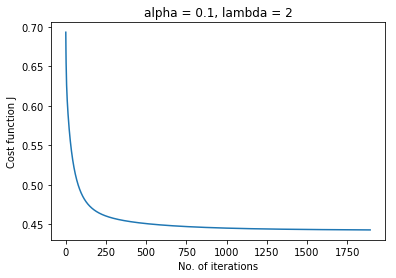

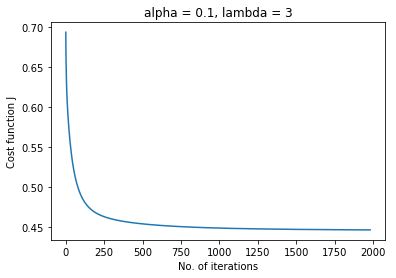

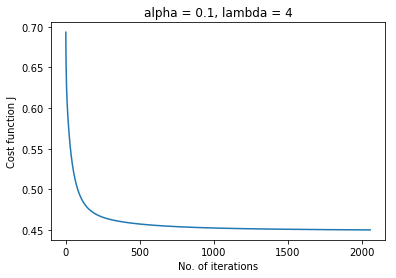

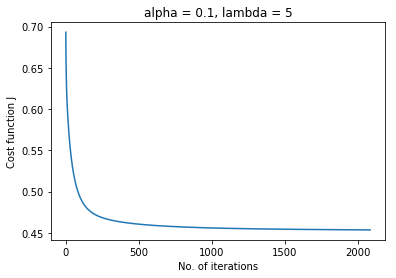

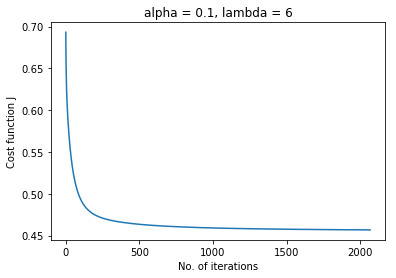

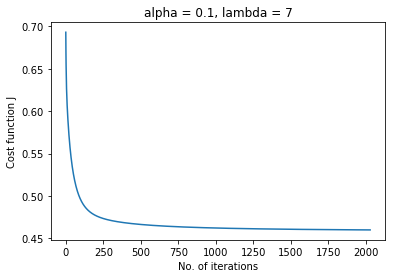

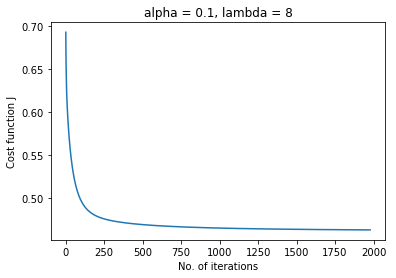

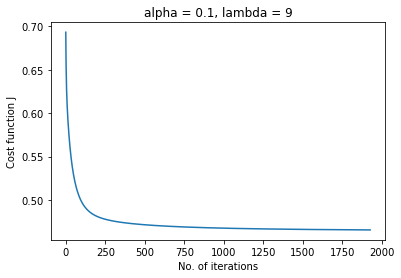

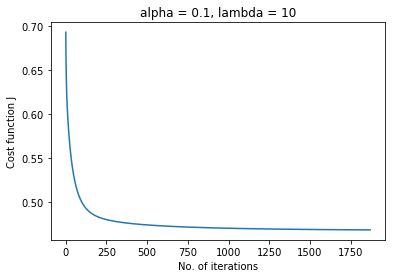

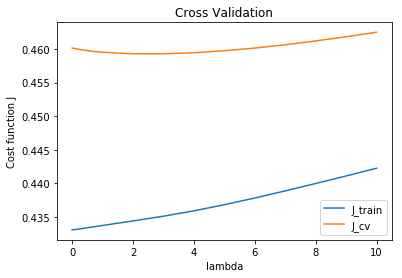

best lambda = 3


In [1657]:
print 'look for best parameters:'
lambdas = [0, 0.00002, 0.00004, 0.00006, 0.00008, 0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[lambda_best, theta_best] = logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas)
print 'best lambda = %r' % lambda_best

In [1677]:
def logistic_regression_predict(theta, X_test):
    X = X_test.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    predict = sigmoid(np.dot(X, theta))
    return predict

In [1680]:
# def f1_score(X_train, X_cv, Y_train, Y_cv, lambdas, alphas):
#     init_theta = np.zeros(X_train.shape[1] + 1)
#     alpha_best = alphas[0]
#     lambda_best = lambdas[0]
#     F1_best = 0
#     theta_best = init_theta
#     print 'alpha\t lambda\t F1 score:'
#     for alpha in alphas:
#         for la in lambdas:
#             [J, theta] = logistic_regression_model(X_train, Y_train, init_theta, la, alpha)
#             y_cv_predict = logistic_regression_predict(theta, X_cv)
            
#             tp = np.dot(y_cv_predict, Y_cv)
#             fp = np.dot(y_cv_predict, 1 - Y_cv)
#             fn = np.dot(1 - np.array(y_cv_predict), Y_cv)

#             precision = tp/(tp + fp)
#             recall = tp/(tp + fn)
#             F1 = 2*precision*recall/(precision + recall)
#             print '%r\t %r\t %r:' % (alpha, la, F1)
            
#             if F1 > F1_best:
#                 F1_best = F1
#                 alpha_best = alpha
#                 lambda_best = la
#                 theta_best = theta
#     return [alpha_best, lambda_best, theta_best]

alpha	 lambda	 F1 score:


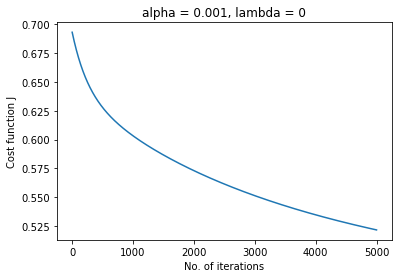

/Users/shaolongchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in long_scalars


0.001	 0	 0:


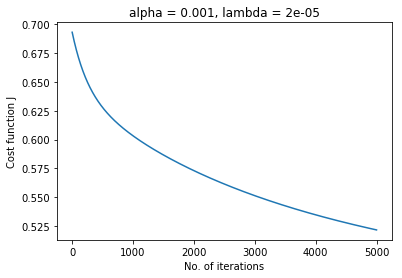

0.001	 2e-05	 0:


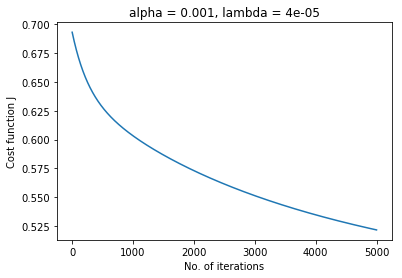

0.001	 4e-05	 0:


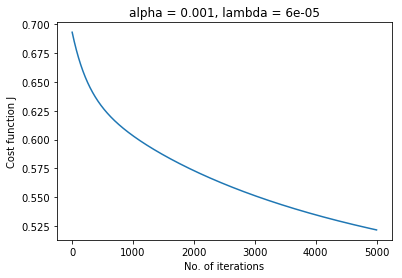

0.001	 6e-05	 0:


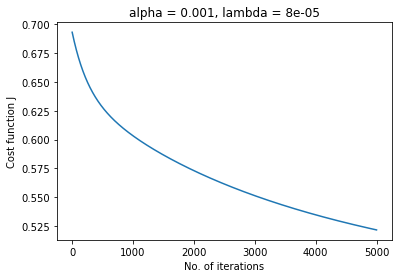

0.001	 8e-05	 0:


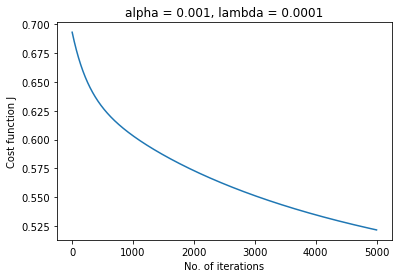

0.001	 0.0001	 0:


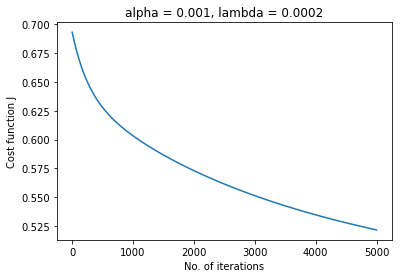

0.001	 0.0002	 0:


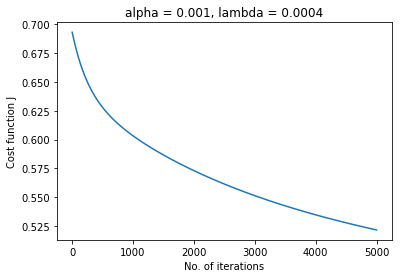

0.001	 0.0004	 0:


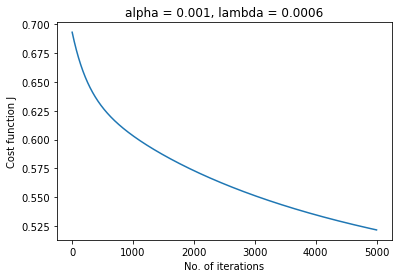

0.001	 0.0006	 0:


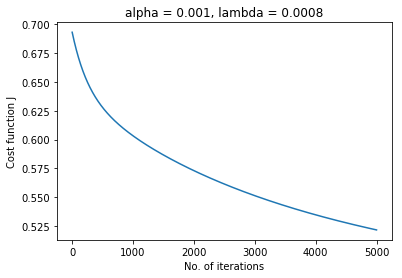

0.001	 0.0008	 0:


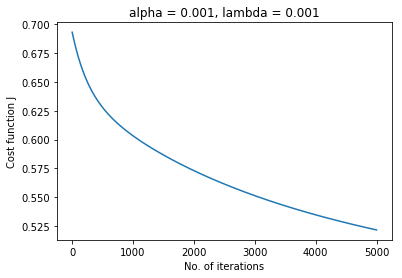

0.001	 0.001	 0:


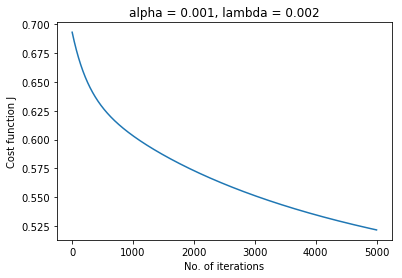

0.001	 0.002	 0:


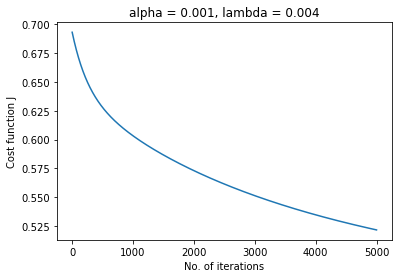

0.001	 0.004	 0:


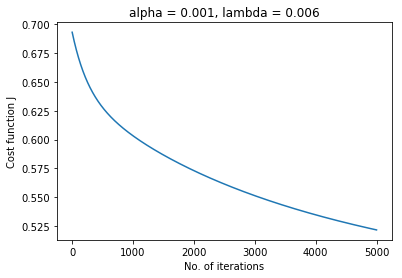

0.001	 0.006	 0:


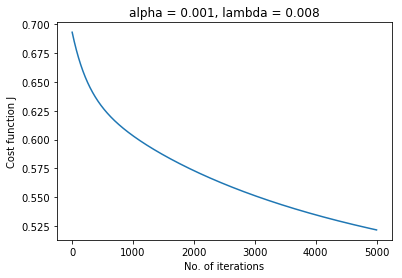

0.001	 0.008	 0:


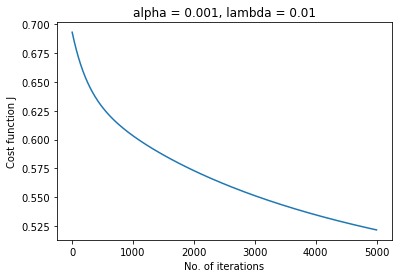

0.001	 0.01	 0:


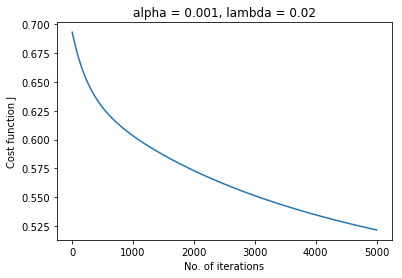

0.001	 0.02	 0:


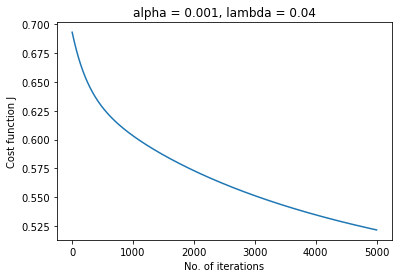

0.001	 0.04	 0:


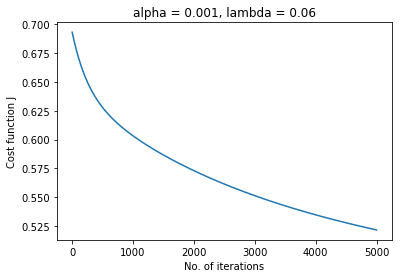

0.001	 0.06	 0:


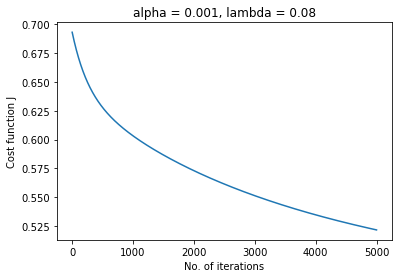

0.001	 0.08	 0:


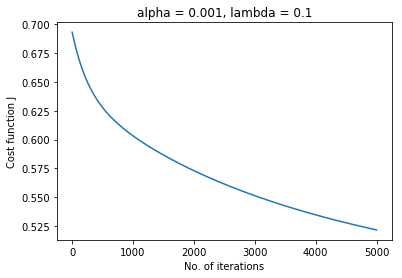

0.001	 0.1	 0:


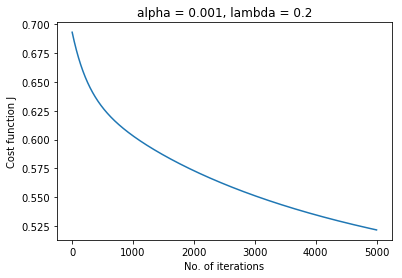

0.001	 0.2	 0:


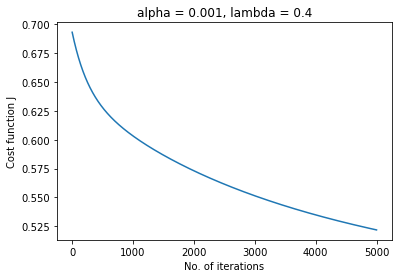

0.001	 0.4	 0:


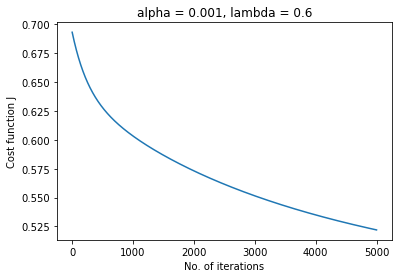

0.001	 0.6	 0:


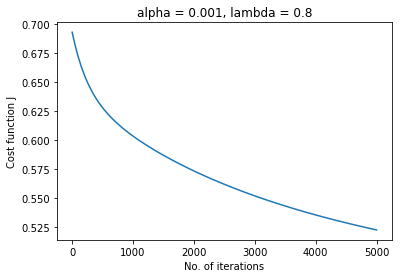

0.001	 0.8	 0:


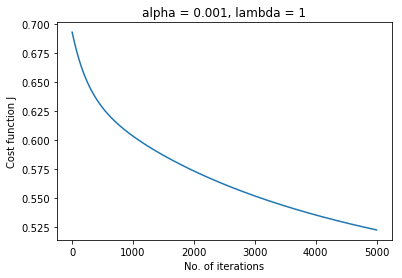

0.001	 1	 0:


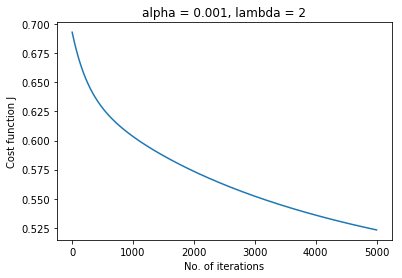

0.001	 2	 0:


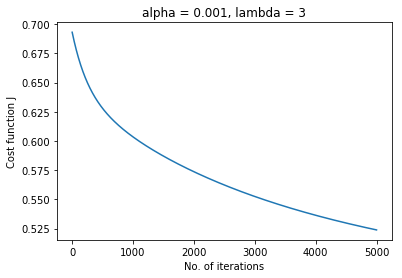

0.001	 3	 0:


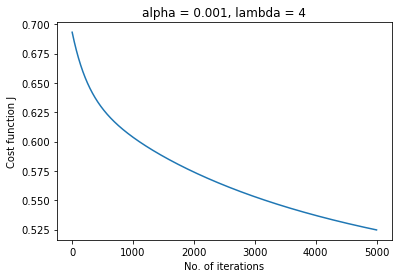

0.001	 4	 0:


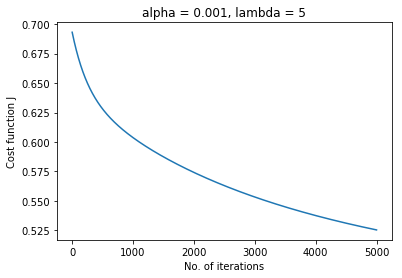

0.001	 5	 0:


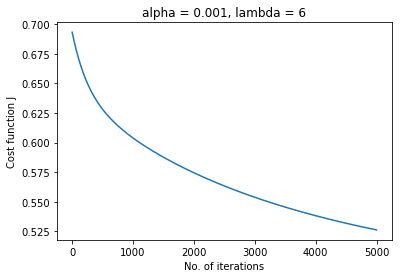

0.001	 6	 0:


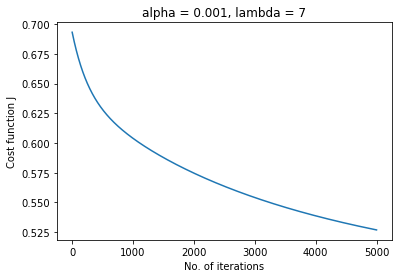

0.001	 7	 0:


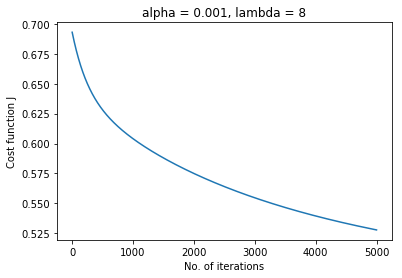

0.001	 8	 0:


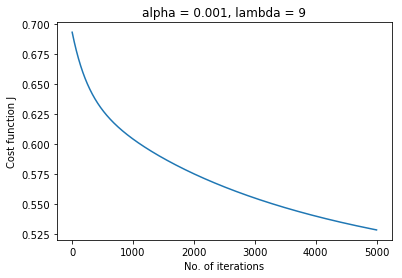

0.001	 9	 0:


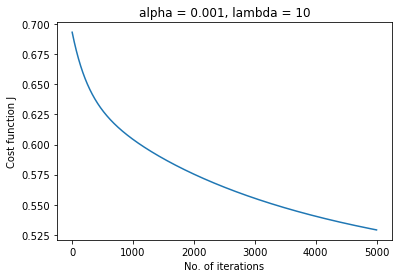

0.001	 10	 0:


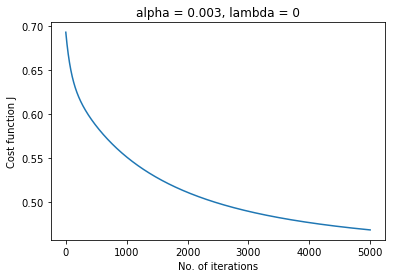

0.003	 0	 0:


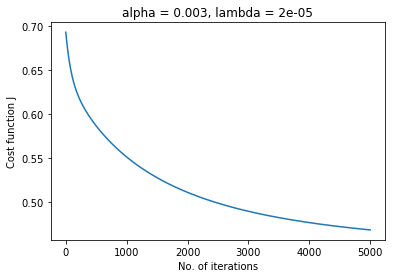

0.003	 2e-05	 0:


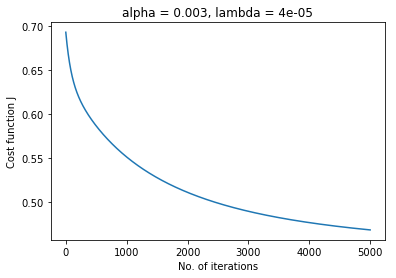

0.003	 4e-05	 0:


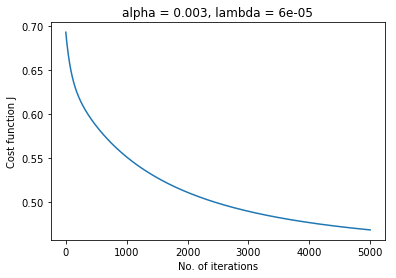

0.003	 6e-05	 0:


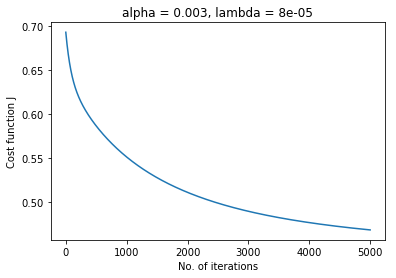

0.003	 8e-05	 0:


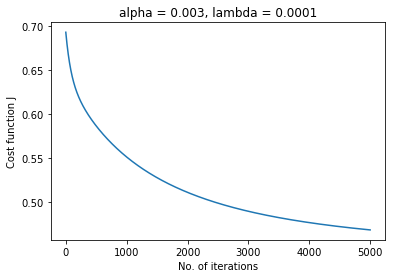

0.003	 0.0001	 0:


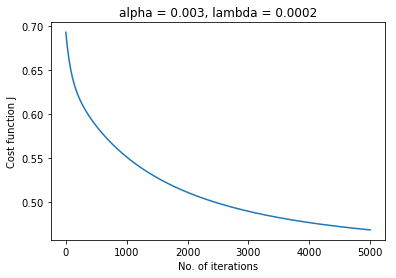

0.003	 0.0002	 0:


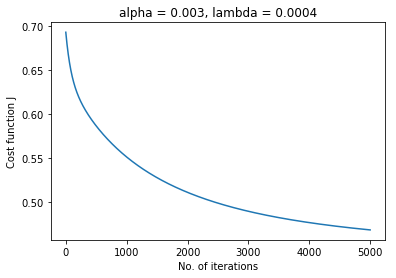

0.003	 0.0004	 0:


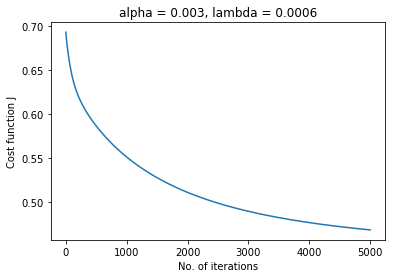

0.003	 0.0006	 0:


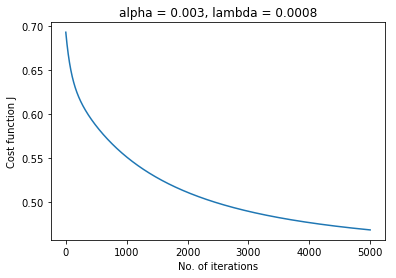

0.003	 0.0008	 0:


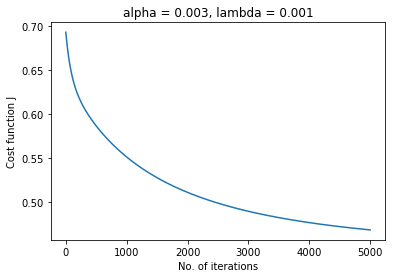

0.003	 0.001	 0:


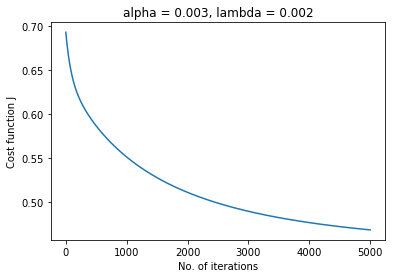

0.003	 0.002	 0:


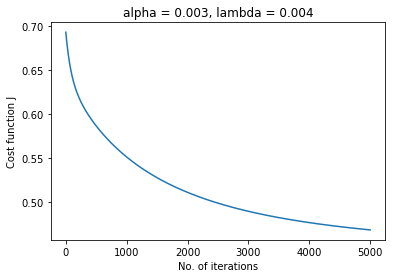

0.003	 0.004	 0:


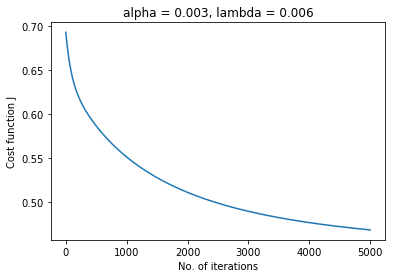

0.003	 0.006	 0:


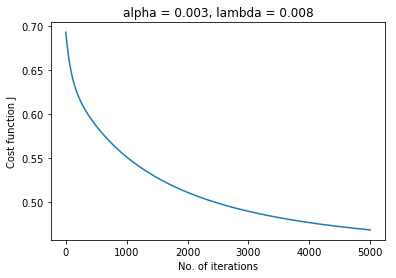

0.003	 0.008	 0:


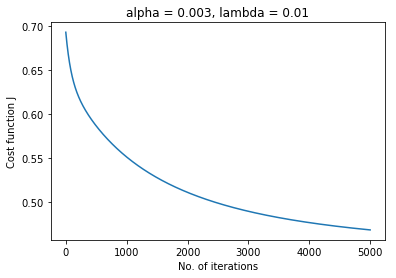

0.003	 0.01	 0:


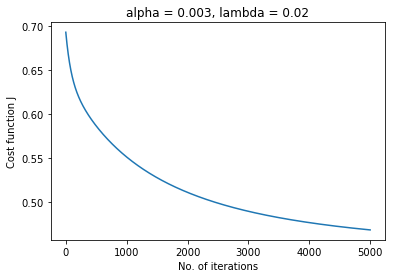

0.003	 0.02	 0:


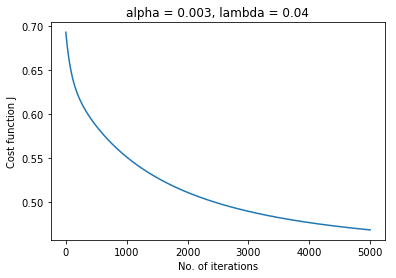

0.003	 0.04	 0:


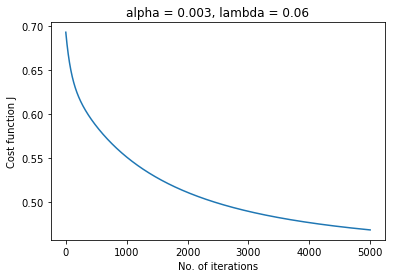

0.003	 0.06	 0:


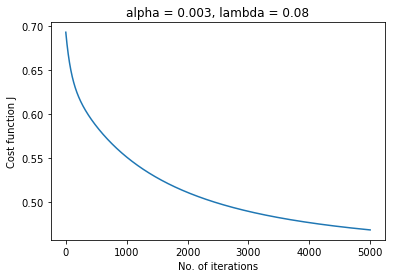

0.003	 0.08	 0:


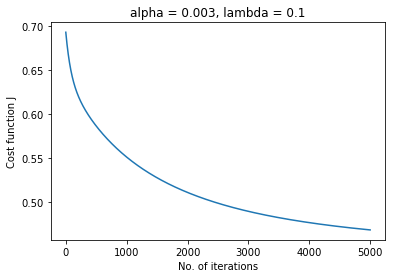

0.003	 0.1	 0:


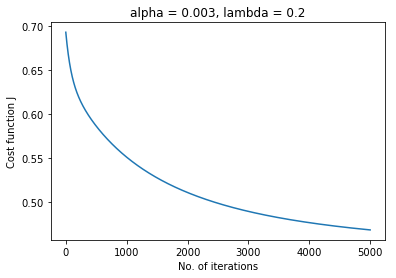

0.003	 0.2	 0:


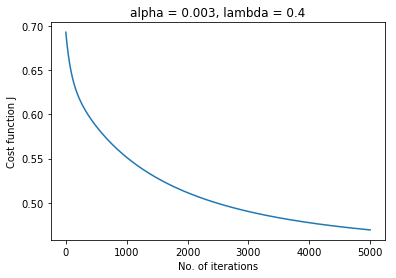

0.003	 0.4	 0:


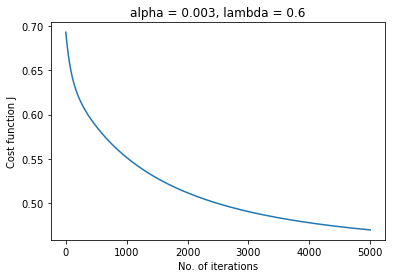

0.003	 0.6	 0:


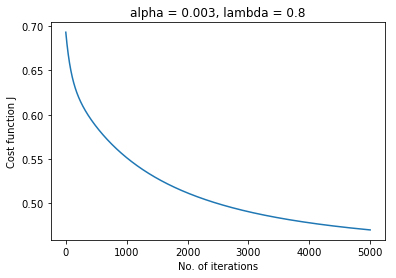

0.003	 0.8	 0:


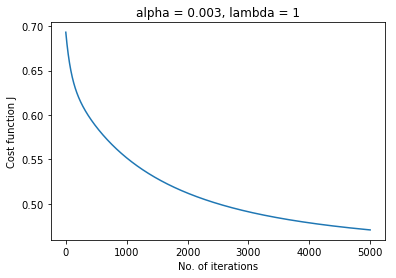

0.003	 1	 0:


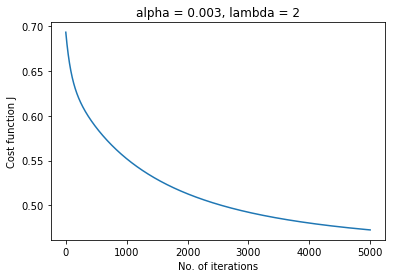

0.003	 2	 0:


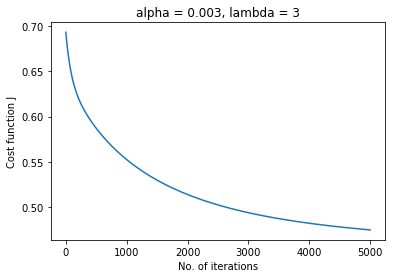

0.003	 3	 0:


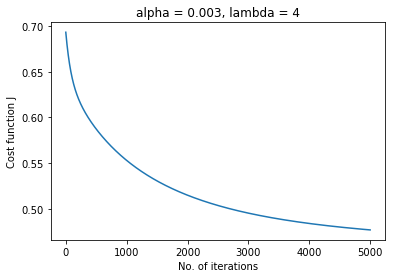

0.003	 4	 0:


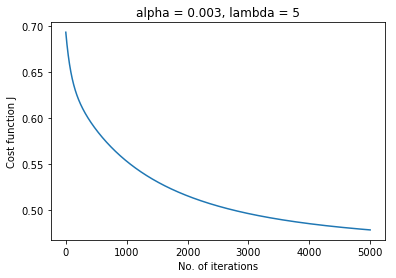

0.003	 5	 0:


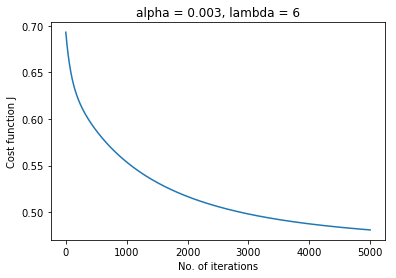

0.003	 6	 0:


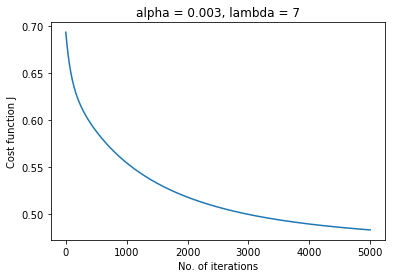

0.003	 7	 0:


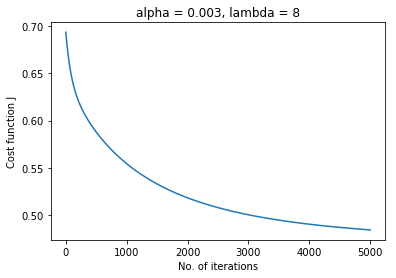

0.003	 8	 0:


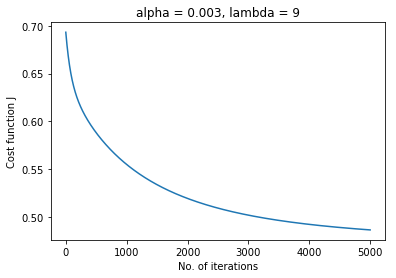

0.003	 9	 0:


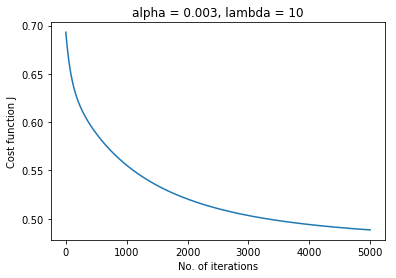

0.003	 10	 0:


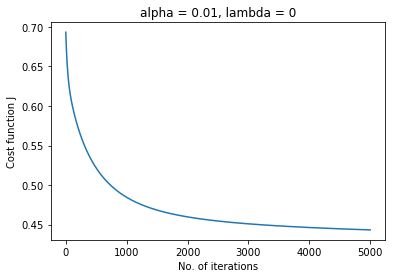

0.01	 0	 0:


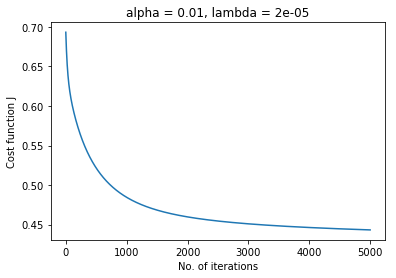

0.01	 2e-05	 0:


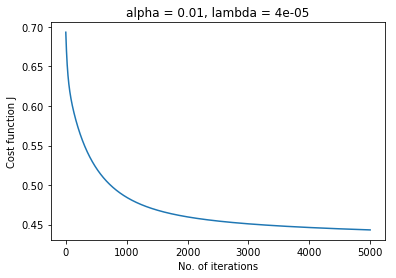

0.01	 4e-05	 0:


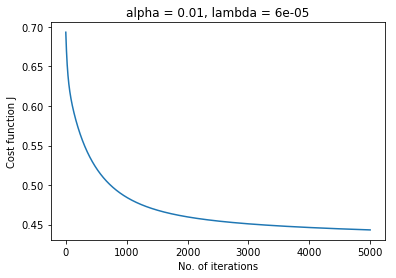

0.01	 6e-05	 0:


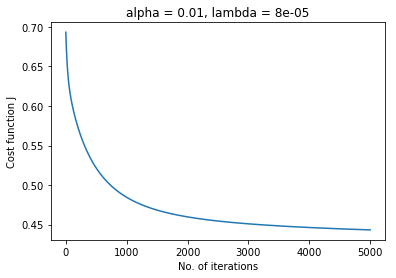

0.01	 8e-05	 0:


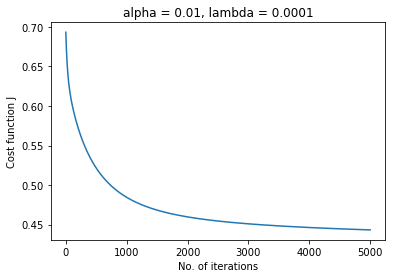

0.01	 0.0001	 0:


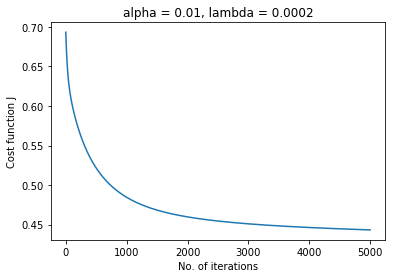

0.01	 0.0002	 0:


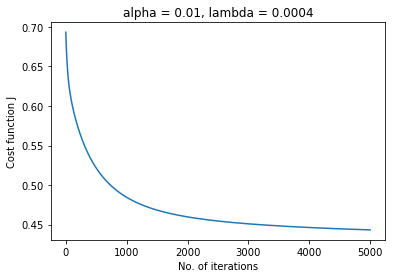

0.01	 0.0004	 0:


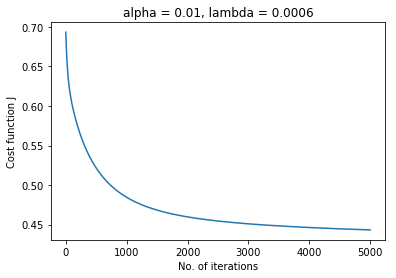

0.01	 0.0006	 0:


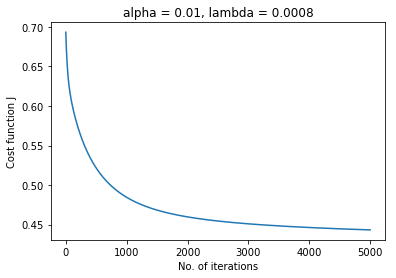

0.01	 0.0008	 0:


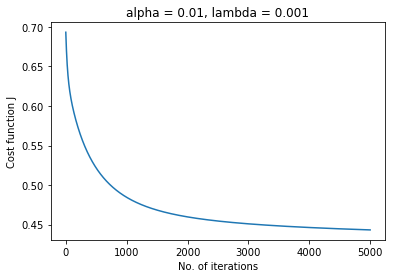

0.01	 0.001	 0:


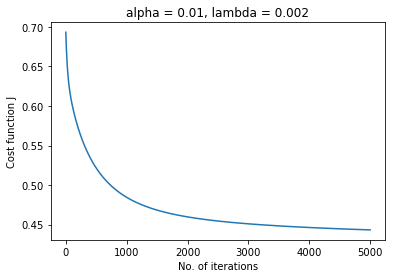

0.01	 0.002	 0:


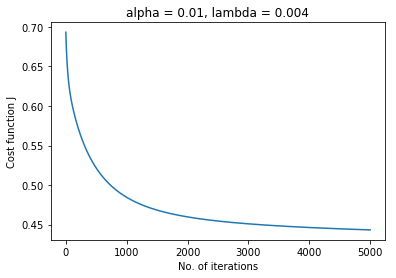

0.01	 0.004	 0:


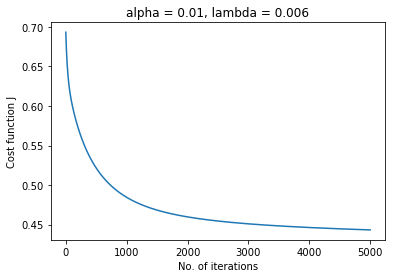

0.01	 0.006	 0:


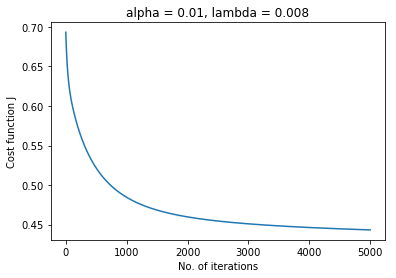

0.01	 0.008	 0:


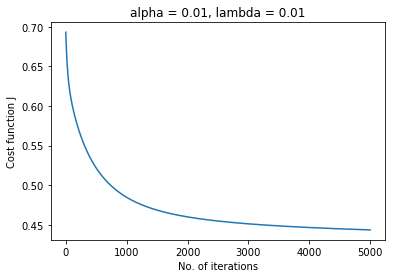

0.01	 0.01	 0:


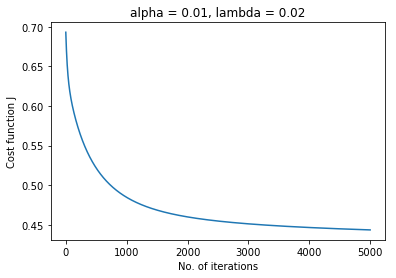

0.01	 0.02	 0:


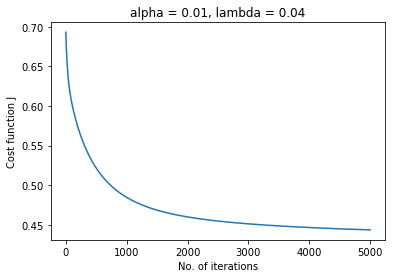

0.01	 0.04	 0:


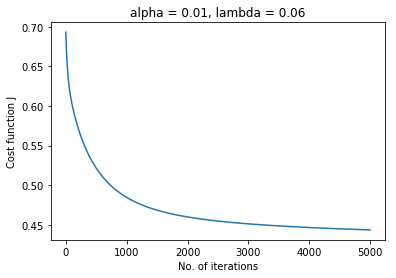

0.01	 0.06	 0:


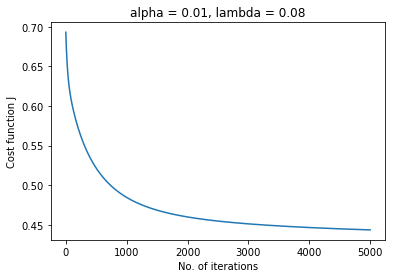

0.01	 0.08	 0:


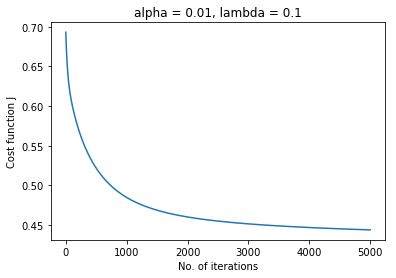

0.01	 0.1	 0:


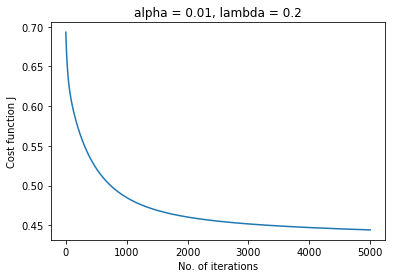

0.01	 0.2	 0:


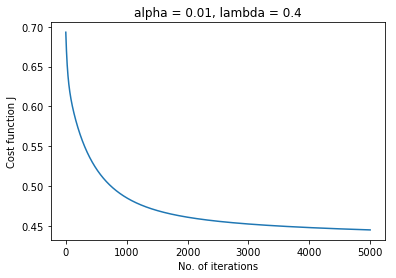

0.01	 0.4	 0:


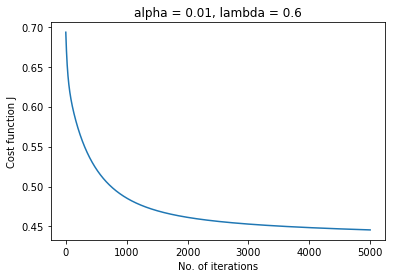

0.01	 0.6	 0:


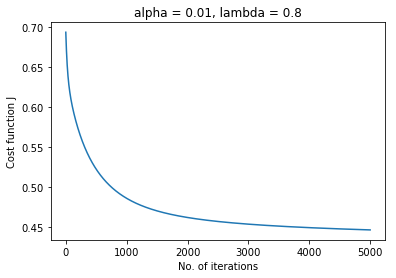

0.01	 0.8	 0:


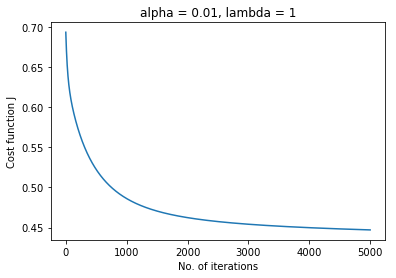

0.01	 1	 0:


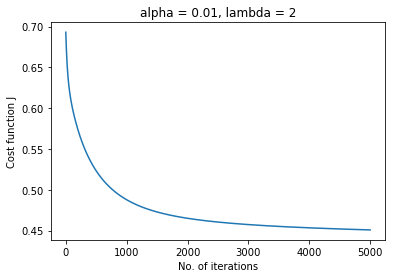

0.01	 2	 0:


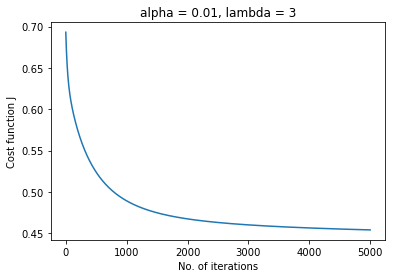

0.01	 3	 0:


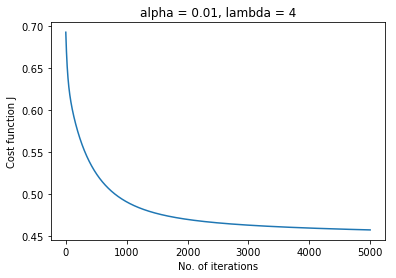

0.01	 4	 0:


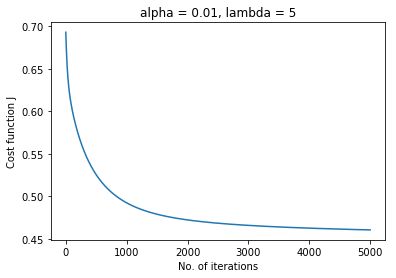

0.01	 5	 0:


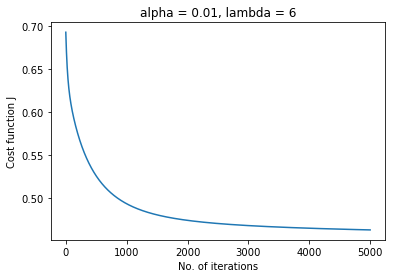

0.01	 6	 0:


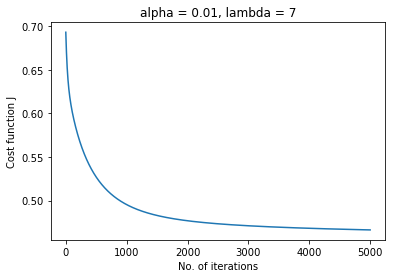

0.01	 7	 0:


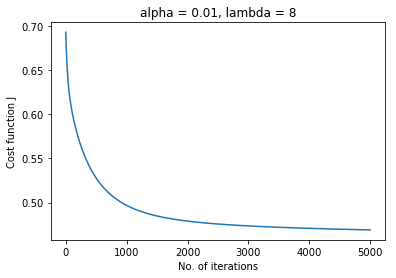

0.01	 8	 0:


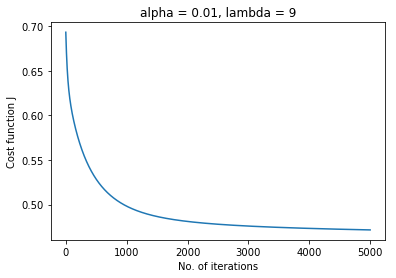

0.01	 9	 0:


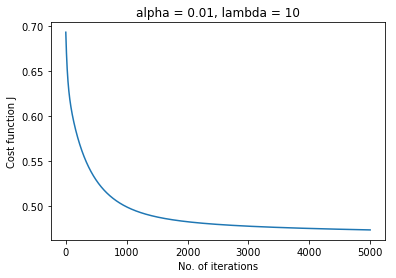

0.01	 10	 0:


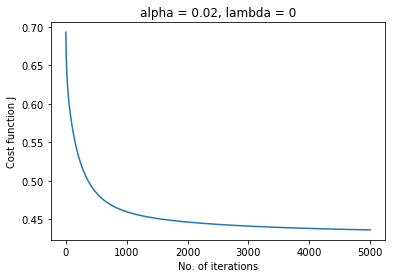

0.02	 0	 0:


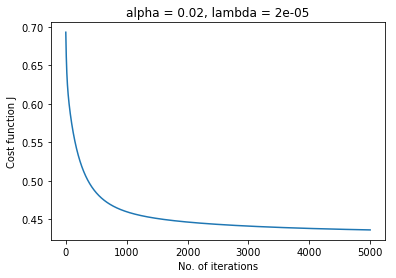

0.02	 2e-05	 0:


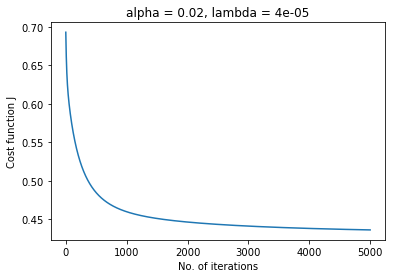

0.02	 4e-05	 0:


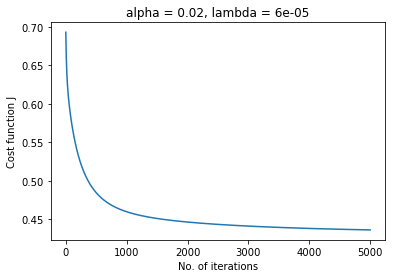

0.02	 6e-05	 0:


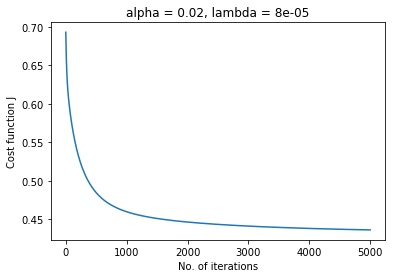

0.02	 8e-05	 0:


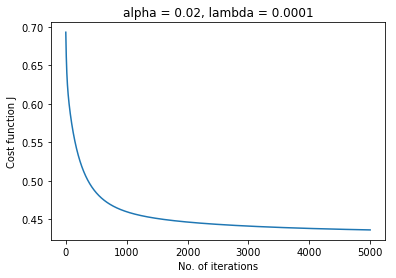

0.02	 0.0001	 0:


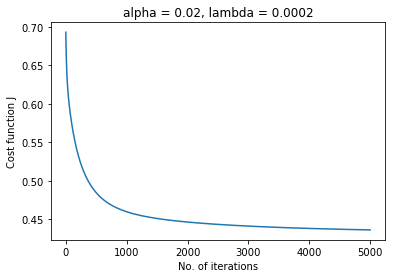

0.02	 0.0002	 0:


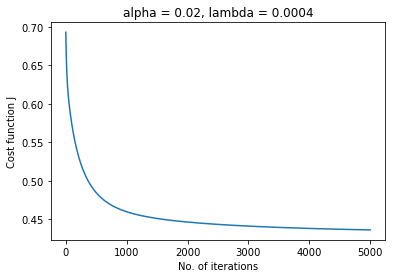

0.02	 0.0004	 0:


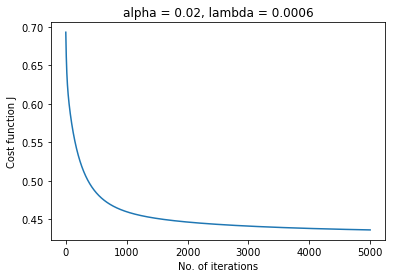

0.02	 0.0006	 0:


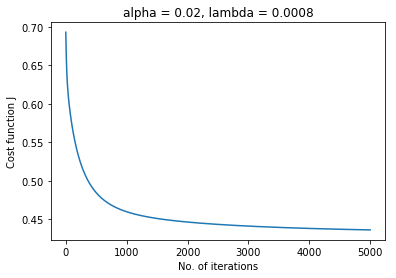

0.02	 0.0008	 0:


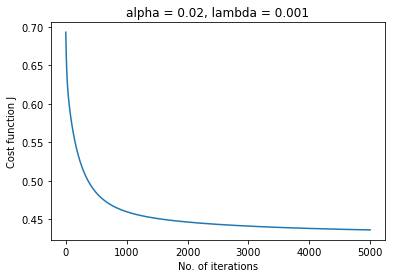

0.02	 0.001	 0:


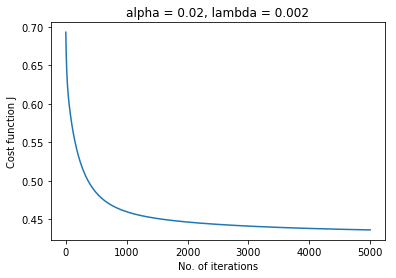

0.02	 0.002	 0:


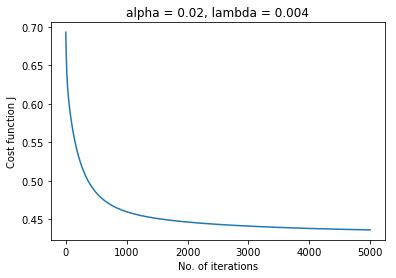

0.02	 0.004	 0:


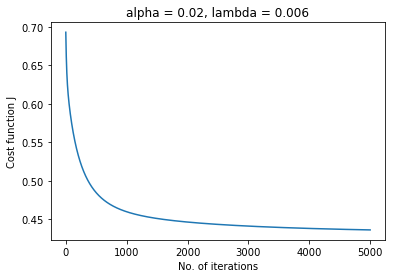

0.02	 0.006	 0:


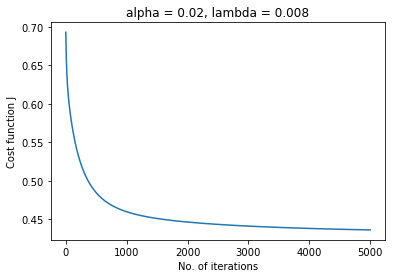

0.02	 0.008	 0:


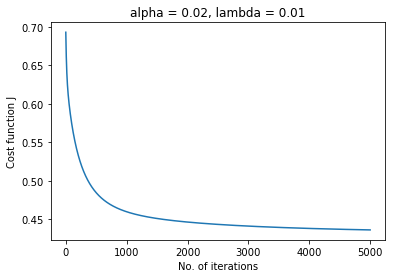

0.02	 0.01	 0:


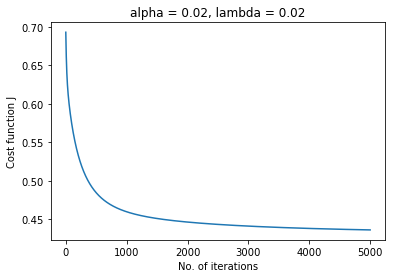

0.02	 0.02	 0:


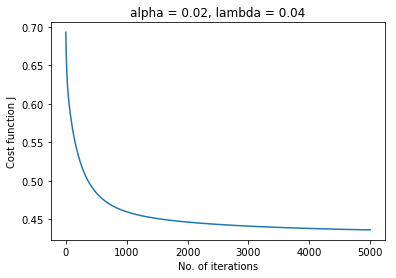

0.02	 0.04	 0:


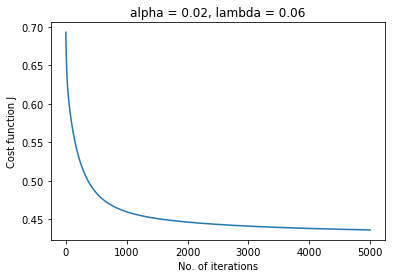

0.02	 0.06	 0:


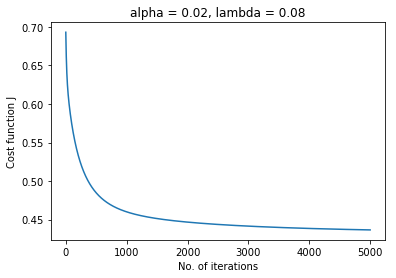

0.02	 0.08	 0:


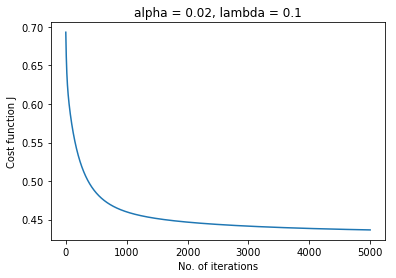

0.02	 0.1	 0:


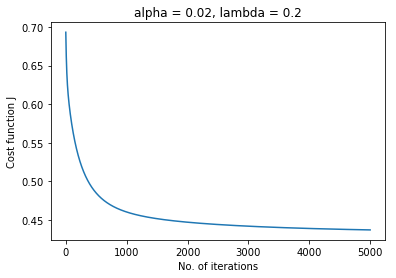

0.02	 0.2	 0:


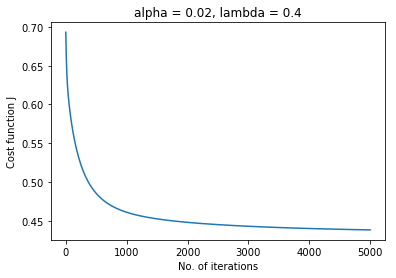

0.02	 0.4	 0:


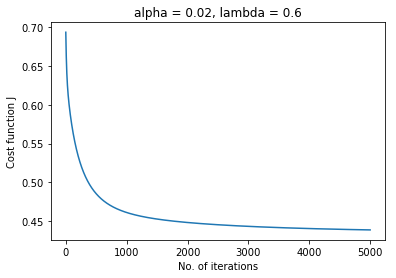

0.02	 0.6	 0:


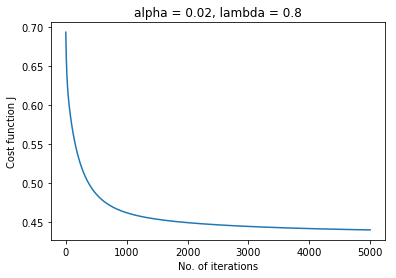

0.02	 0.8	 0:


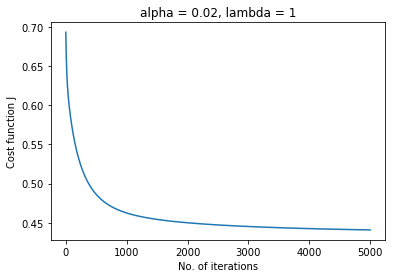

0.02	 1	 0:


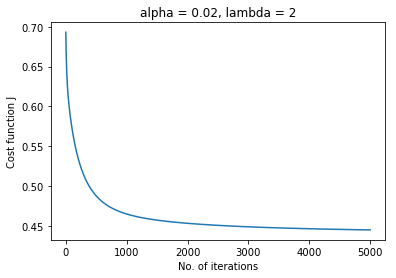

0.02	 2	 0:


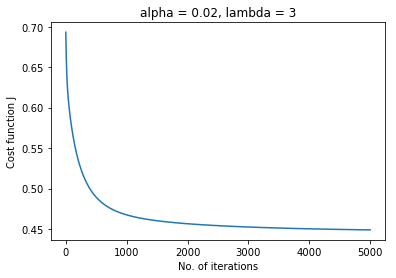

0.02	 3	 0:


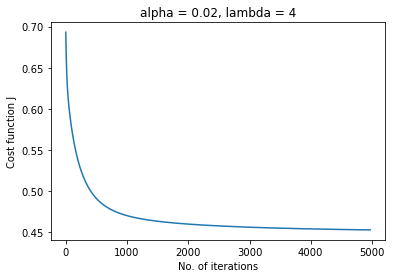

0.02	 4	 0:


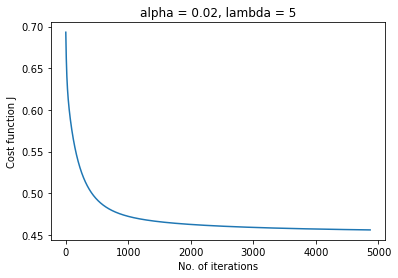

0.02	 5	 0:


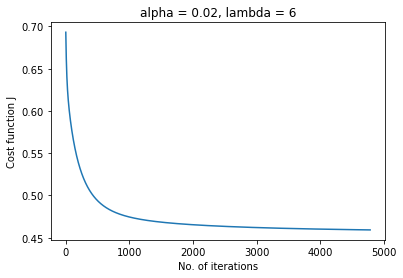

0.02	 6	 0:


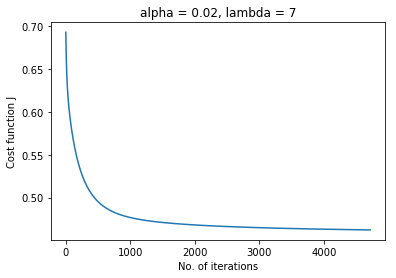

0.02	 7	 0:


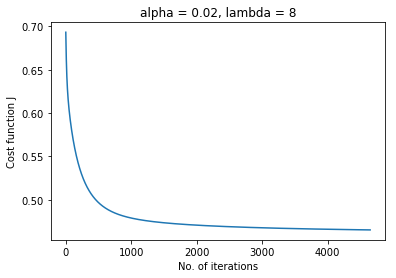

0.02	 8	 0:


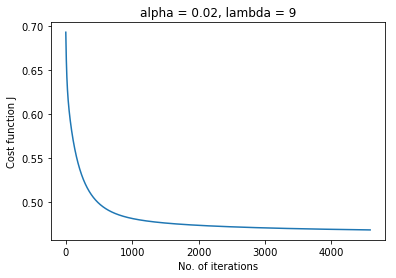

0.02	 9	 0:


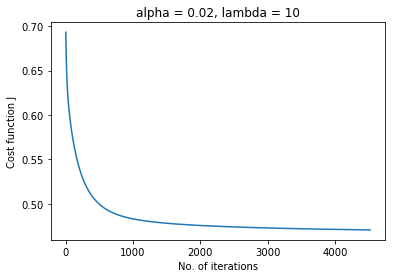

0.02	 10	 0:


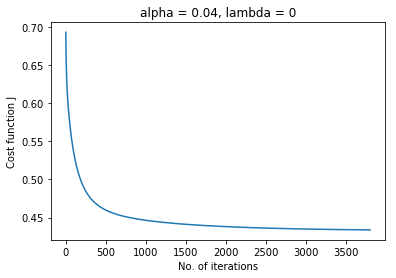

0.04	 0	 0:


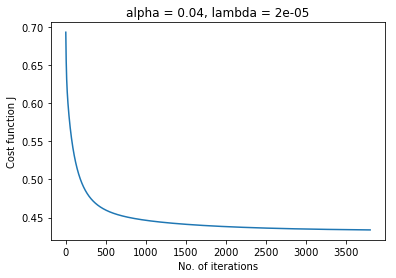

0.04	 2e-05	 0:


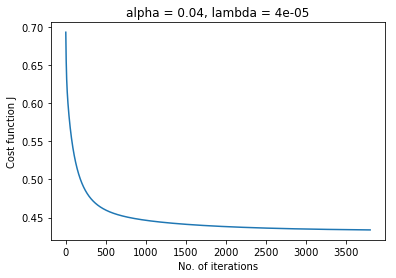

0.04	 4e-05	 0:


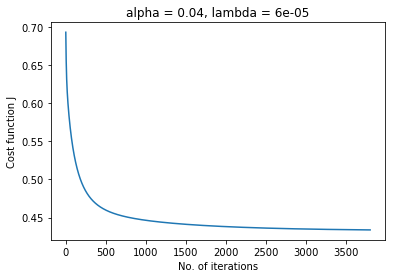

0.04	 6e-05	 0:


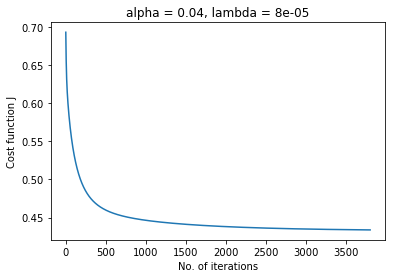

0.04	 8e-05	 0:


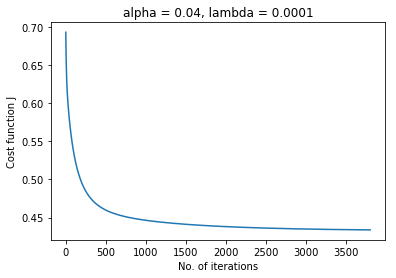

0.04	 0.0001	 0:


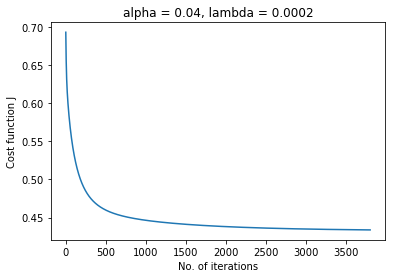

0.04	 0.0002	 0:


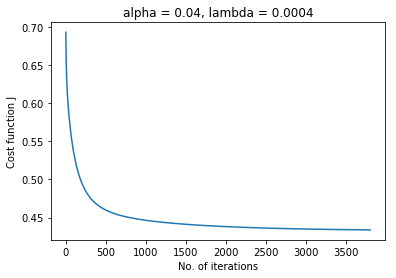

0.04	 0.0004	 0:


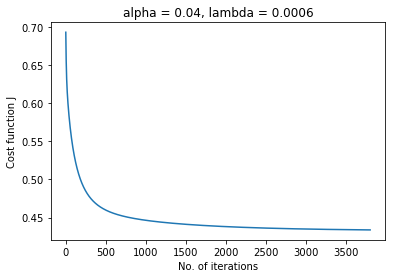

0.04	 0.0006	 0:


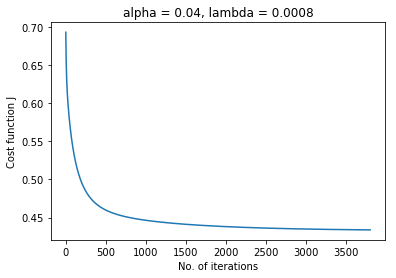

0.04	 0.0008	 0:


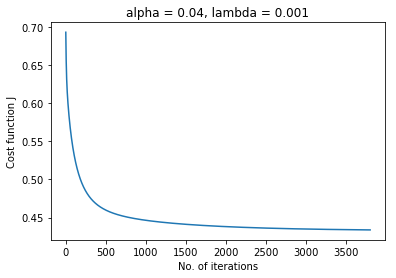

0.04	 0.001	 0:


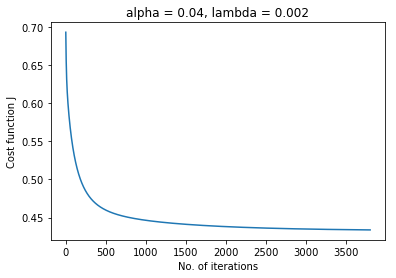

0.04	 0.002	 0:


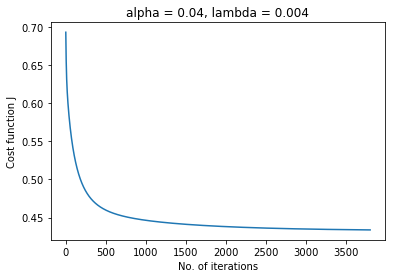

0.04	 0.004	 0:


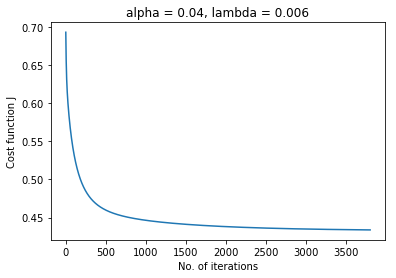

0.04	 0.006	 0:


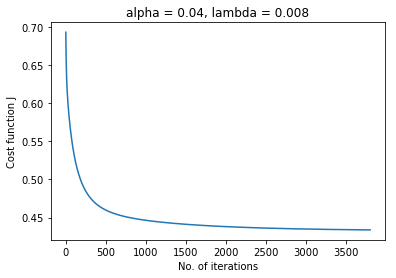

0.04	 0.008	 0:


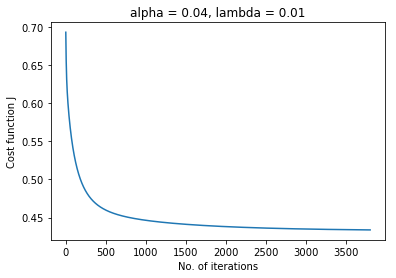

0.04	 0.01	 0:


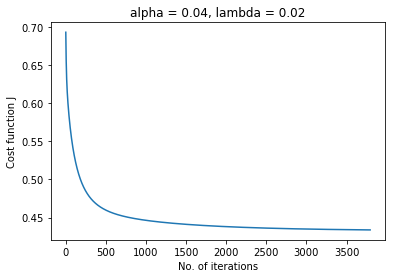

0.04	 0.02	 0:


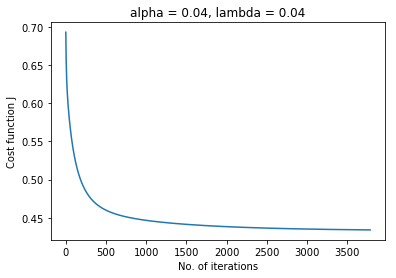

0.04	 0.04	 0:


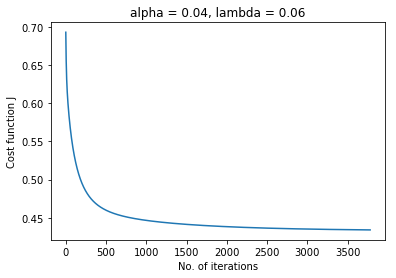

0.04	 0.06	 0:


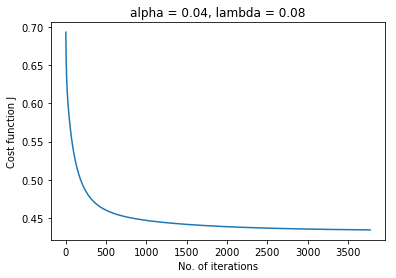

0.04	 0.08	 0:


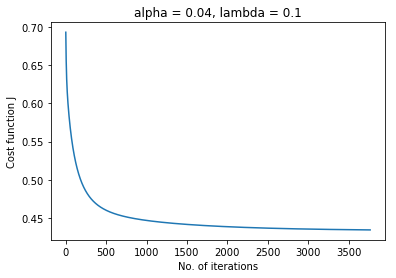

0.04	 0.1	 0:


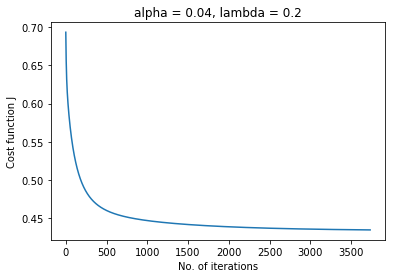

0.04	 0.2	 0:


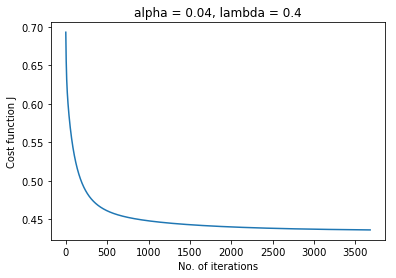

0.04	 0.4	 0:


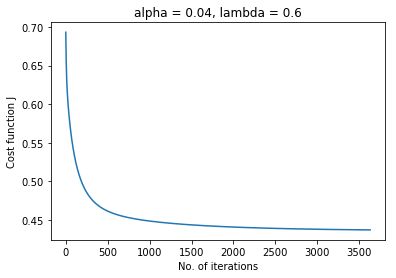

0.04	 0.6	 0:


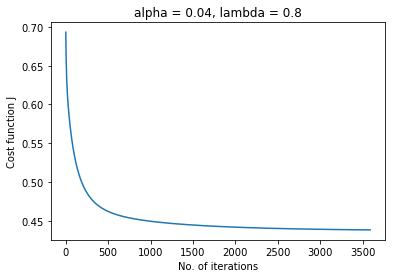

0.04	 0.8	 0:


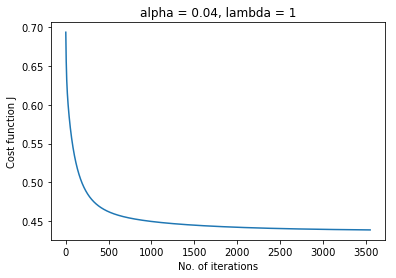

0.04	 1	 0:


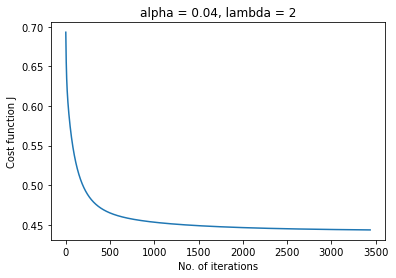

0.04	 2	 0:


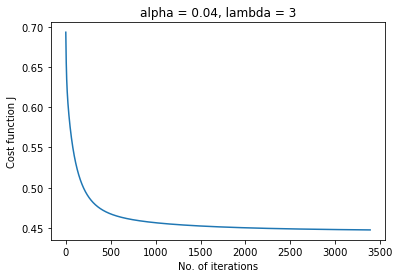

0.04	 3	 0:


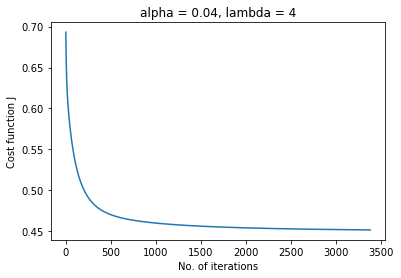

0.04	 4	 0:


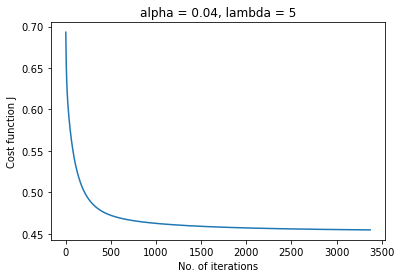

0.04	 5	 0:


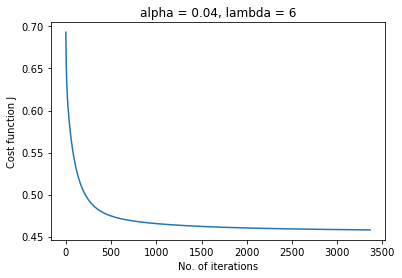

0.04	 6	 0:


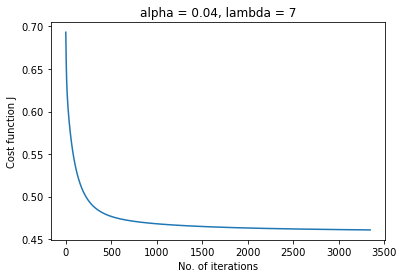

0.04	 7	 0:


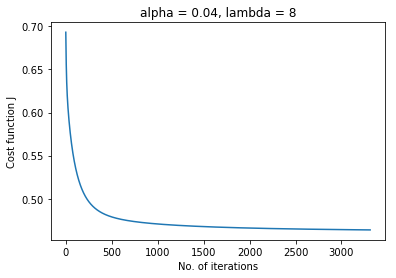

0.04	 8	 0:


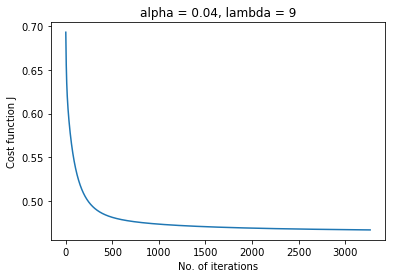

0.04	 9	 0:


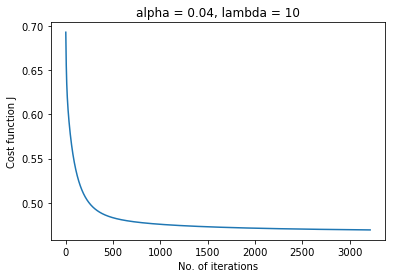

0.04	 10	 0:


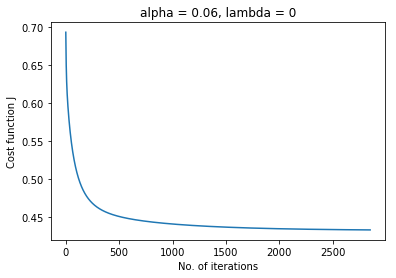

0.06	 0	 0:


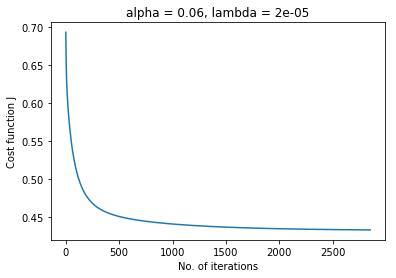

0.06	 2e-05	 0:


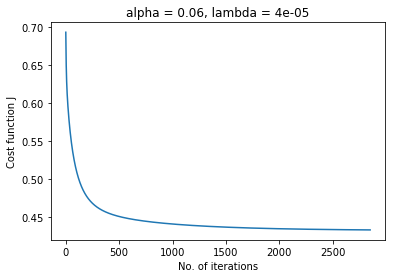

0.06	 4e-05	 0:


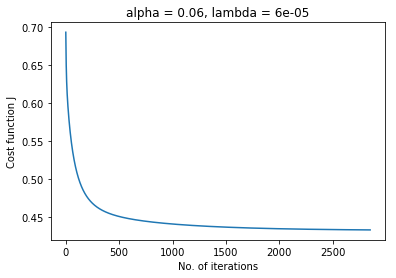

0.06	 6e-05	 0:


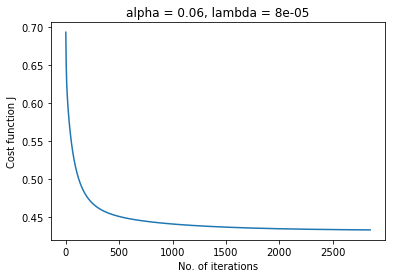

0.06	 8e-05	 0:


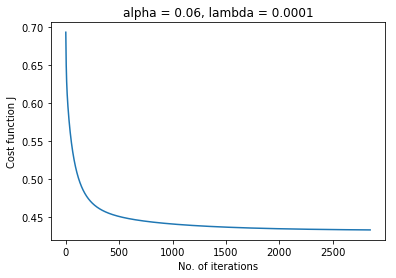

0.06	 0.0001	 0:


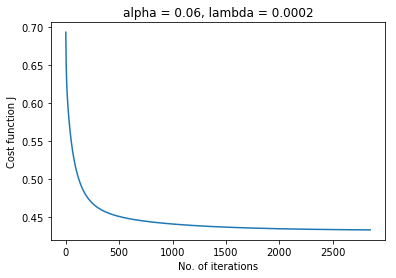

0.06	 0.0002	 0:


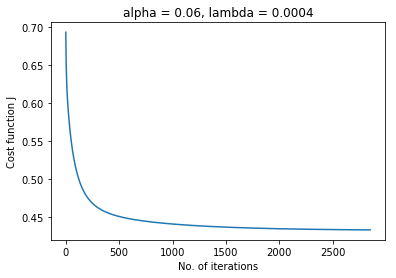

0.06	 0.0004	 0:


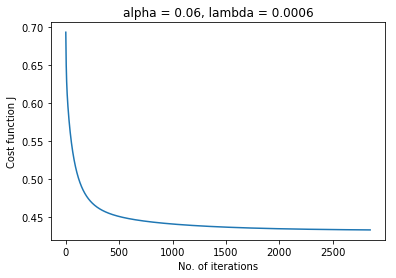

0.06	 0.0006	 0:


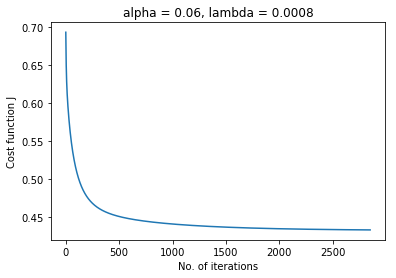

0.06	 0.0008	 0:


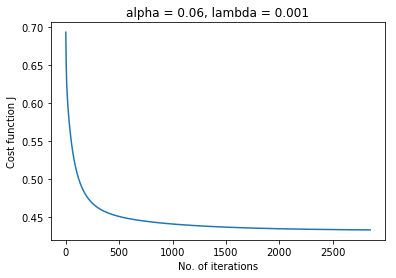

0.06	 0.001	 0:


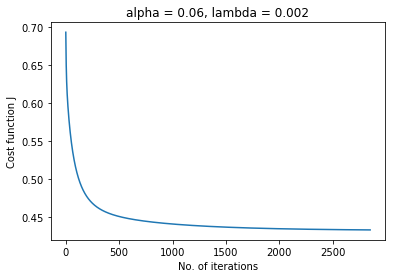

0.06	 0.002	 0:


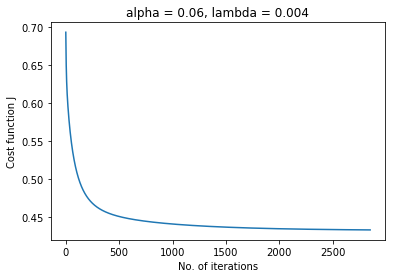

0.06	 0.004	 0:


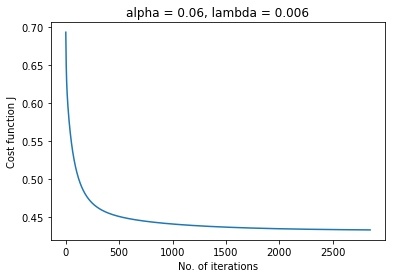

0.06	 0.006	 0:


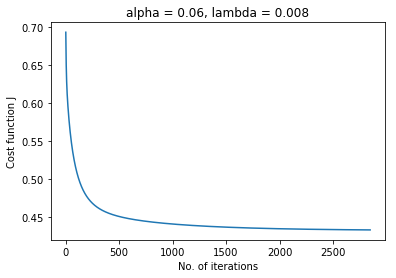

0.06	 0.008	 0:


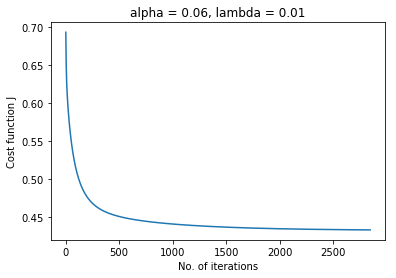

0.06	 0.01	 0:


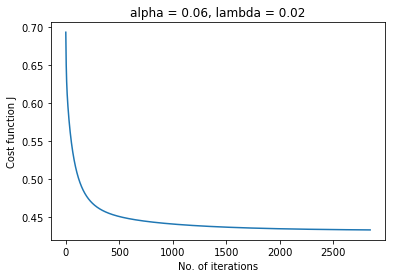

0.06	 0.02	 0:


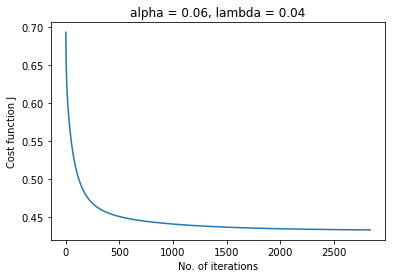

0.06	 0.04	 0:


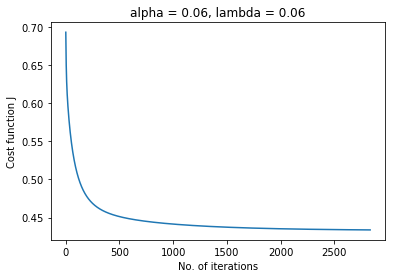

0.06	 0.06	 0:


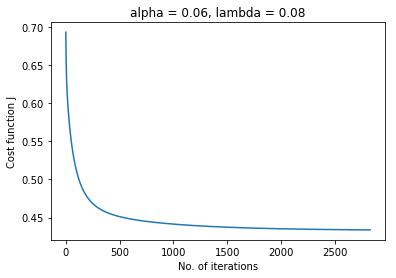

0.06	 0.08	 0:


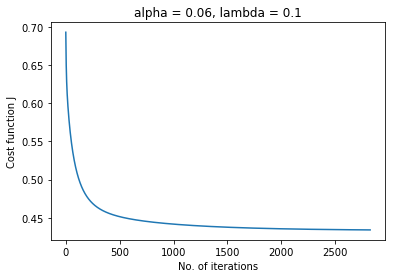

0.06	 0.1	 0:


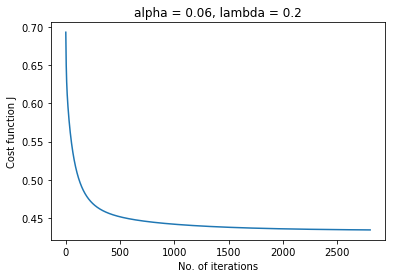

0.06	 0.2	 0:


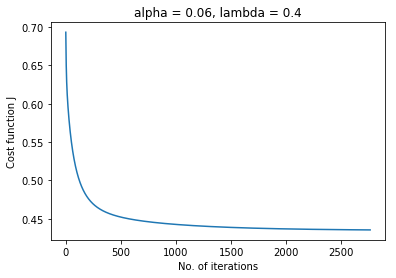

0.06	 0.4	 0:


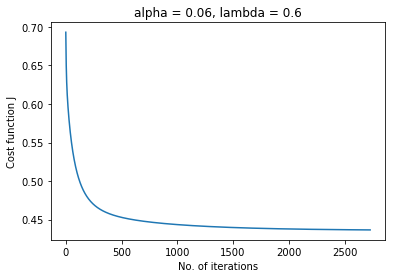

0.06	 0.6	 0:


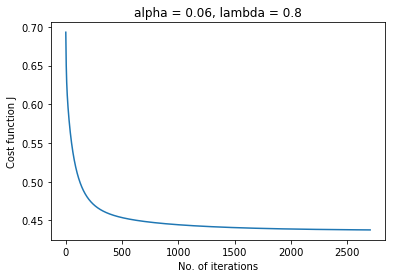

0.06	 0.8	 0:


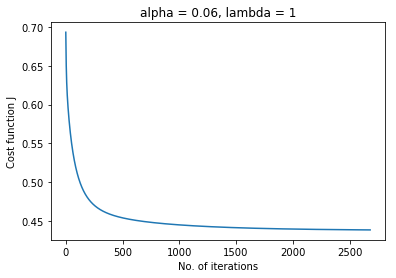

0.06	 1	 0:


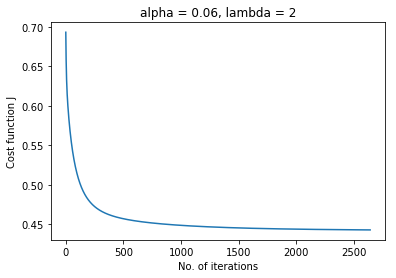

0.06	 2	 0:


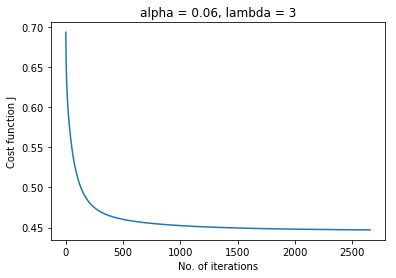

0.06	 3	 0:


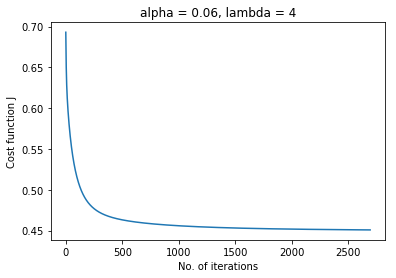

0.06	 4	 0:


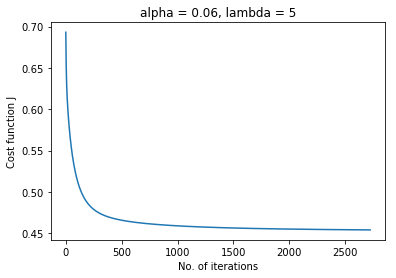

0.06	 5	 0:


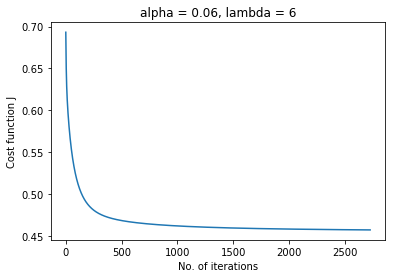

0.06	 6	 0:


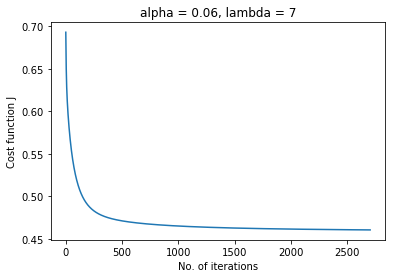

0.06	 7	 0:


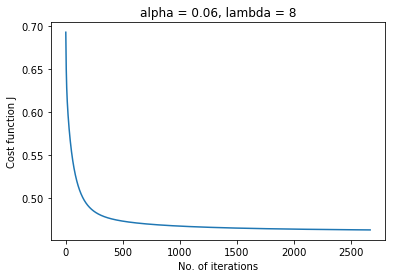

0.06	 8	 0:


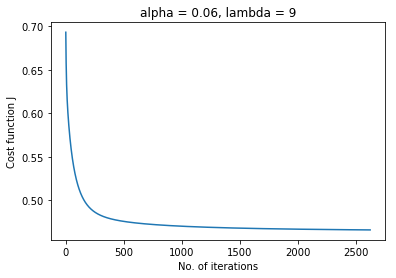

0.06	 9	 0:


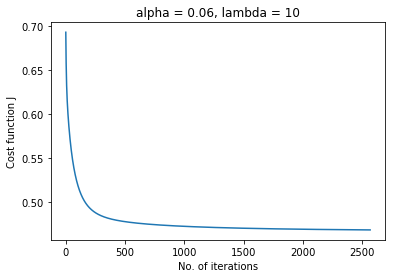

0.06	 10	 0:


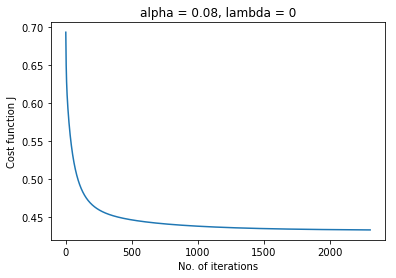

0.08	 0	 0:


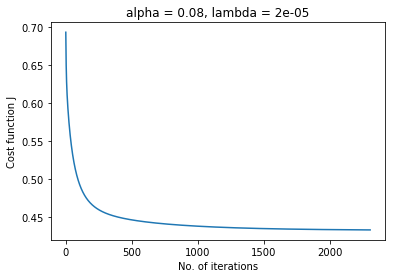

0.08	 2e-05	 0:


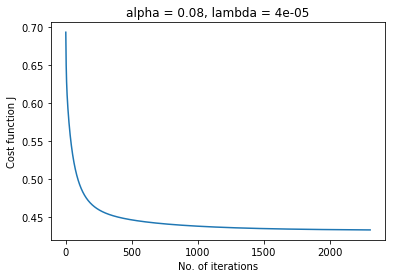

0.08	 4e-05	 0:


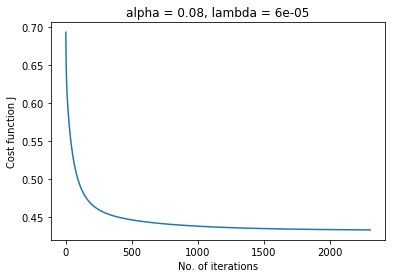

0.08	 6e-05	 0:


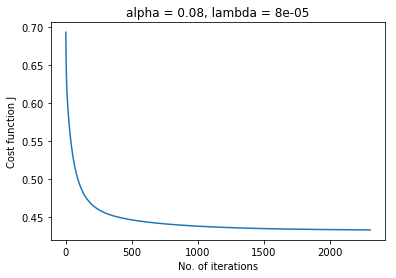

0.08	 8e-05	 0:


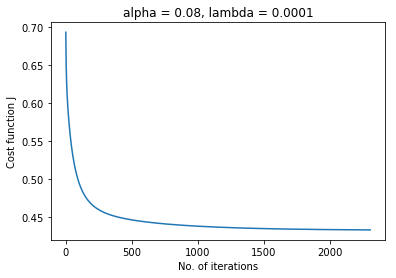

0.08	 0.0001	 0:


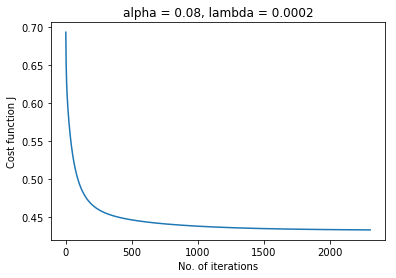

0.08	 0.0002	 0:


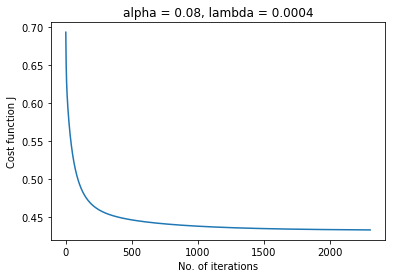

0.08	 0.0004	 0:


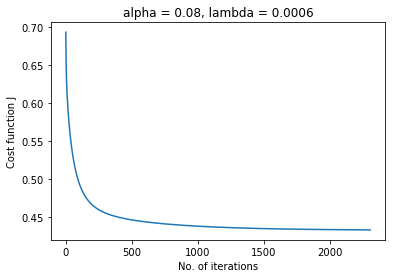

0.08	 0.0006	 0:


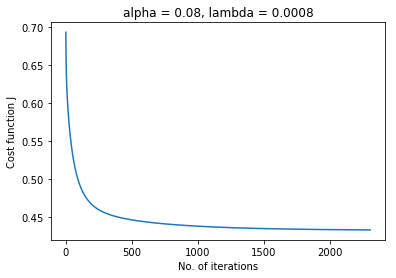

0.08	 0.0008	 0:


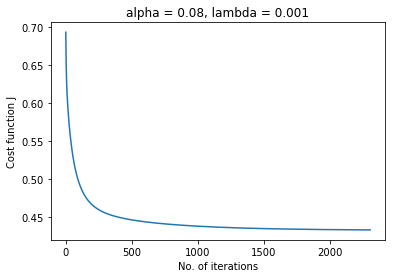

0.08	 0.001	 0:


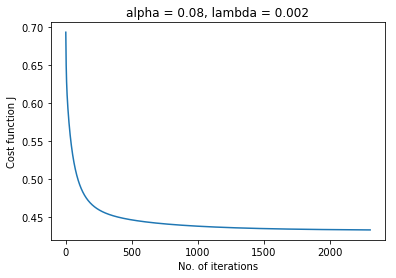

0.08	 0.002	 0:


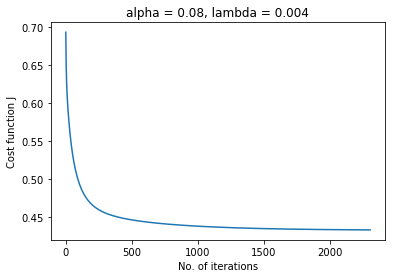

0.08	 0.004	 0:


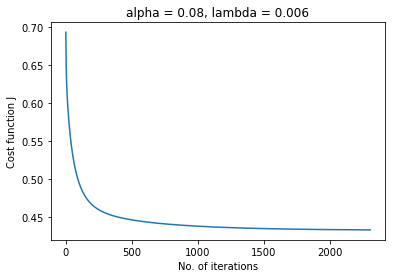

0.08	 0.006	 0:


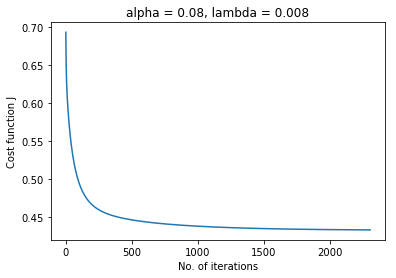

0.08	 0.008	 0:


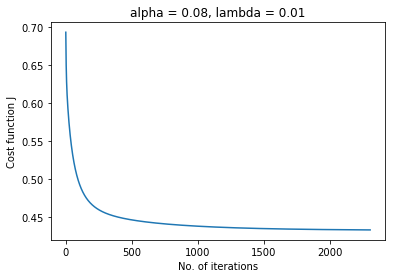

0.08	 0.01	 0:


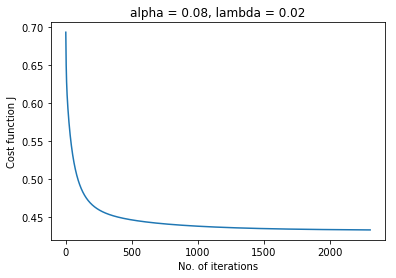

0.08	 0.02	 0:


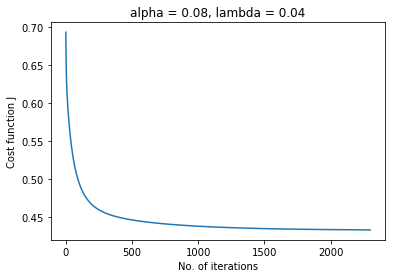

0.08	 0.04	 0:


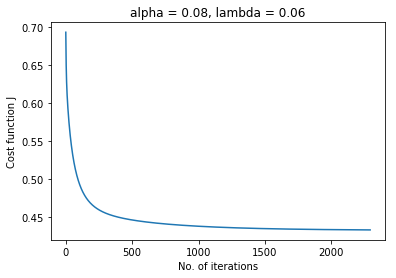

0.08	 0.06	 0:


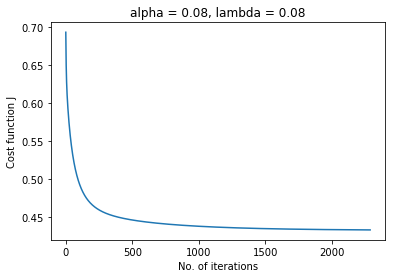

0.08	 0.08	 0:


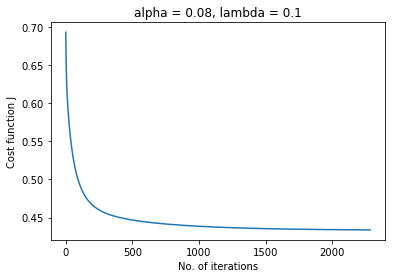

0.08	 0.1	 0:


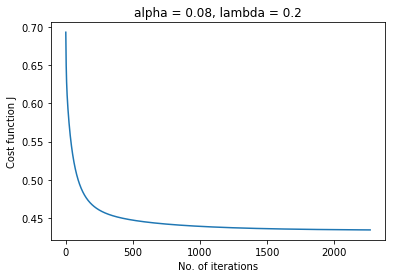

0.08	 0.2	 0:


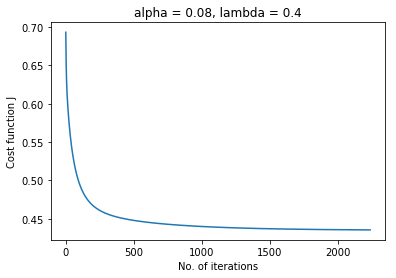

0.08	 0.4	 0:


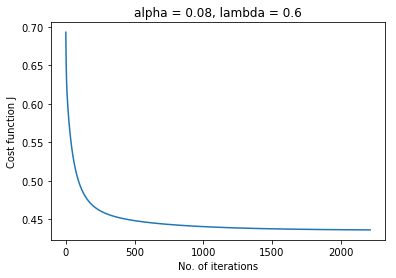

0.08	 0.6	 0:


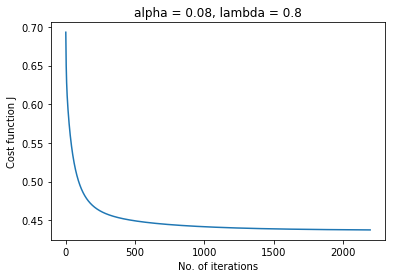

0.08	 0.8	 0:


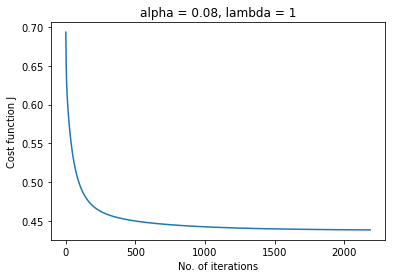

0.08	 1	 0:


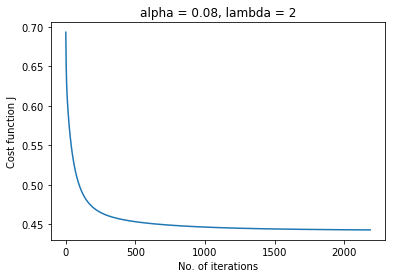

0.08	 2	 0:


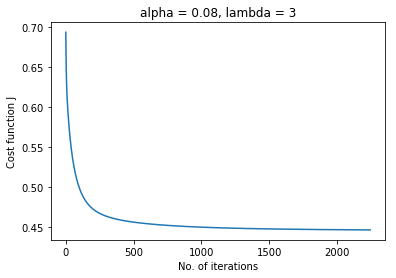

0.08	 3	 0:


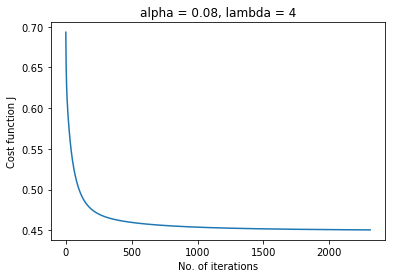

0.08	 4	 0:


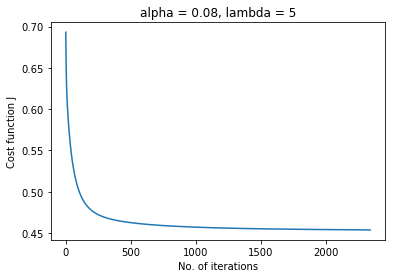

0.08	 5	 0:


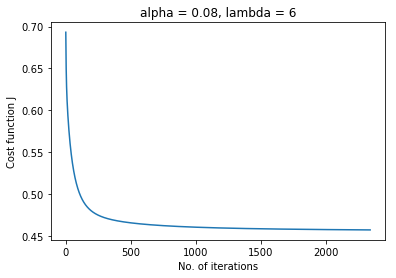

0.08	 6	 0:


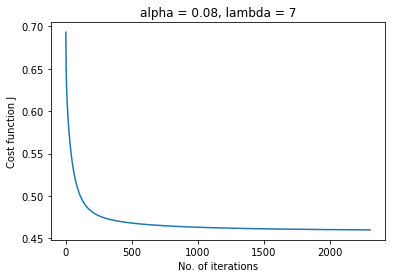

0.08	 7	 0:


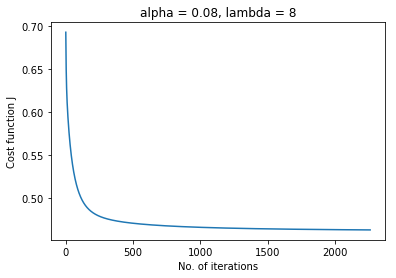

0.08	 8	 0:


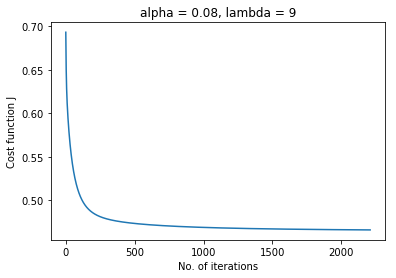

0.08	 9	 0:


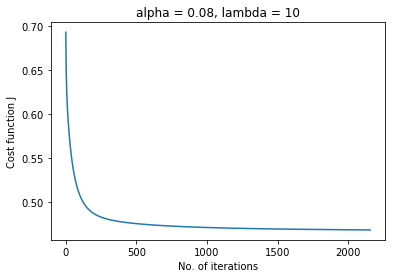

0.08	 10	 0:


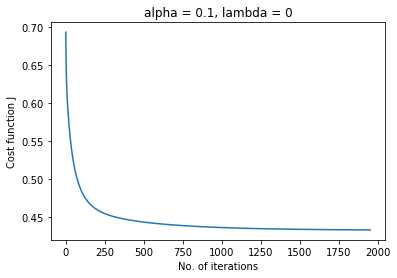

0.1	 0	 0:


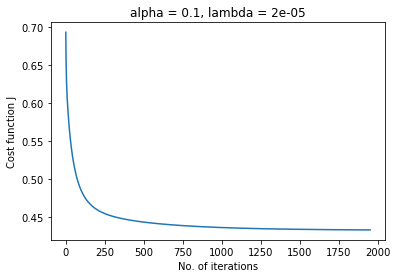

0.1	 2e-05	 0:


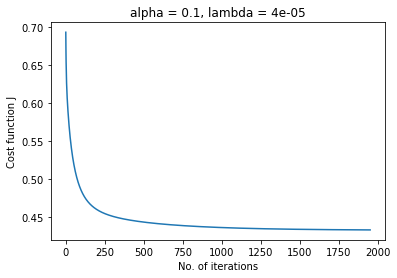

0.1	 4e-05	 0:


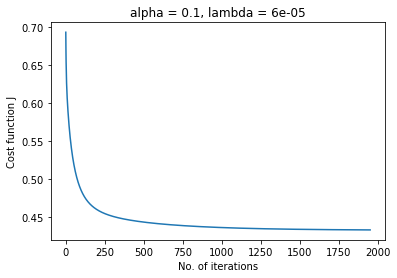

0.1	 6e-05	 0:


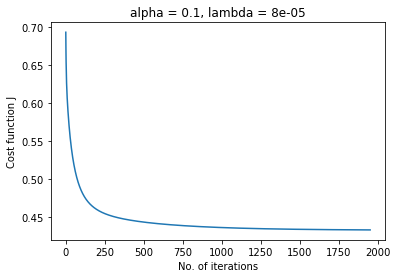

0.1	 8e-05	 0:


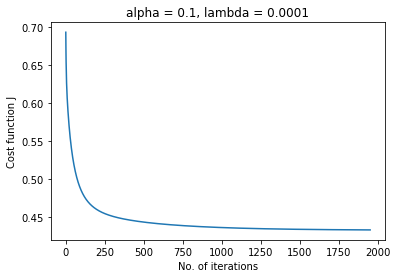

0.1	 0.0001	 0:


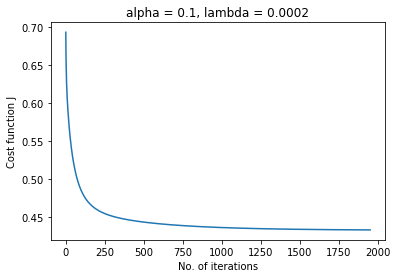

0.1	 0.0002	 0:


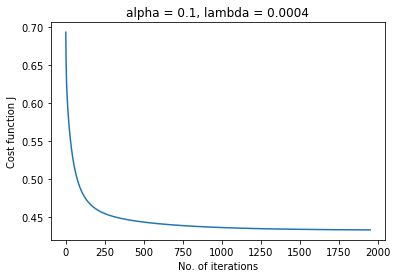

0.1	 0.0004	 0:


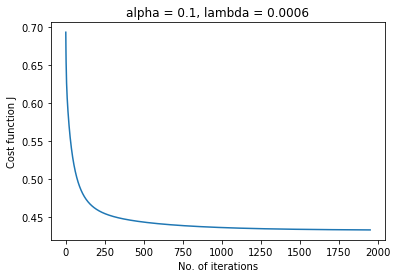

0.1	 0.0006	 0:


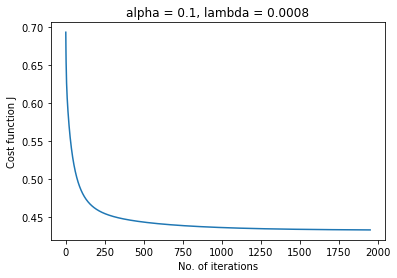

0.1	 0.0008	 0:


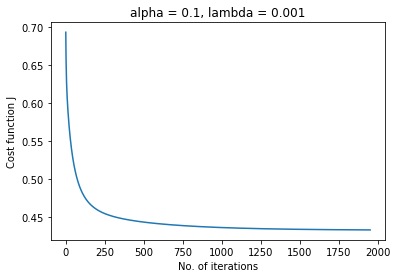

0.1	 0.001	 0:


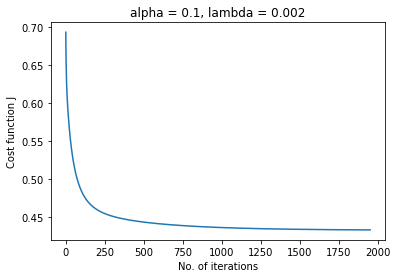

0.1	 0.002	 0:


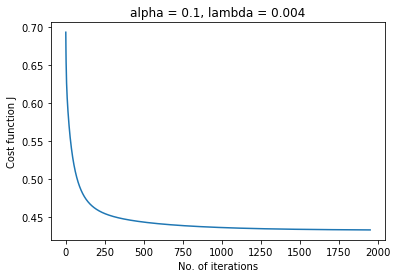

0.1	 0.004	 0:


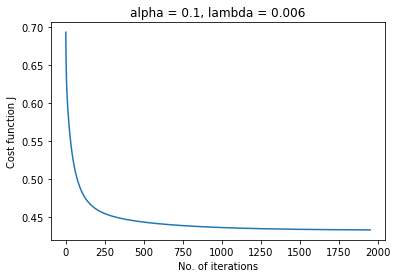

0.1	 0.006	 0:


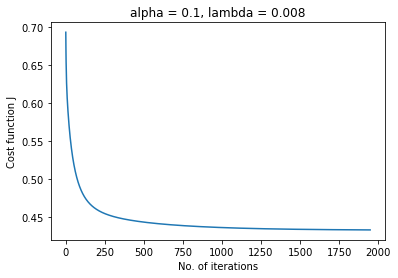

0.1	 0.008	 0:


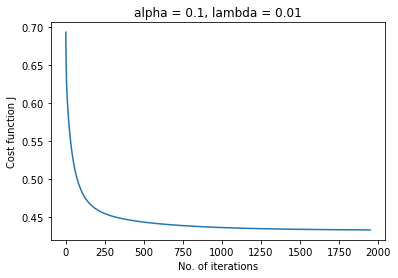

0.1	 0.01	 0:


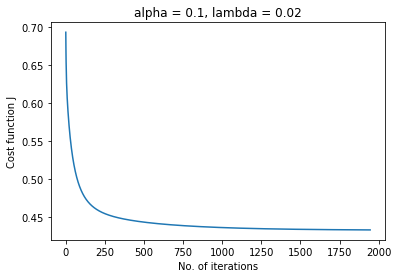

0.1	 0.02	 0:


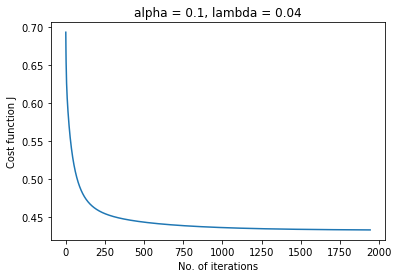

0.1	 0.04	 0:


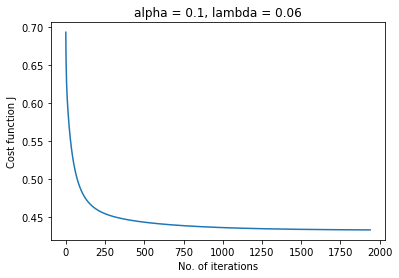

0.1	 0.06	 0:


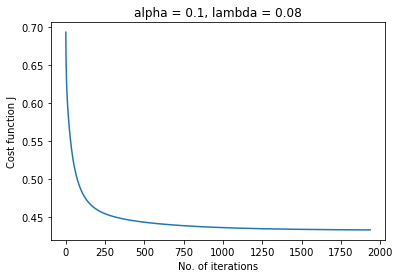

0.1	 0.08	 0:


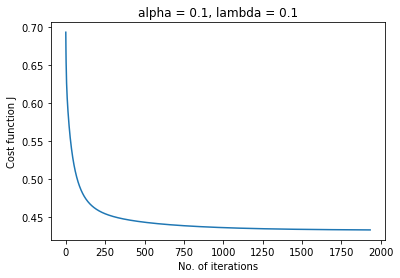

0.1	 0.1	 0:


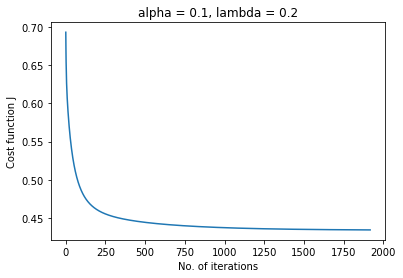

0.1	 0.2	 0:


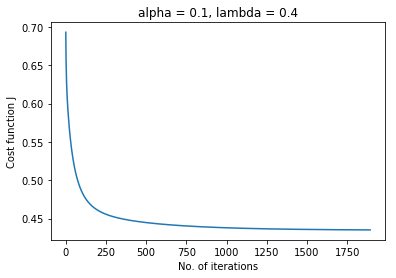

0.1	 0.4	 0:


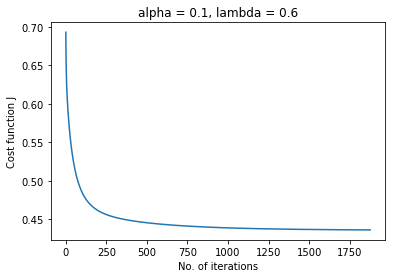

0.1	 0.6	 0:


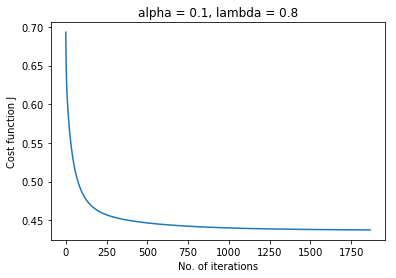

0.1	 0.8	 0:


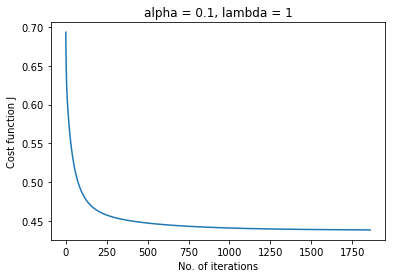

0.1	 1	 0:


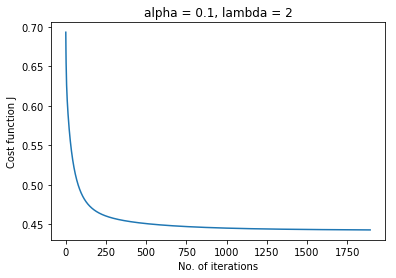

0.1	 2	 0:


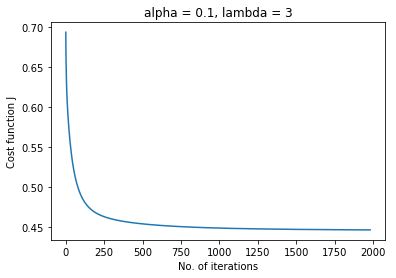

0.1	 3	 0:


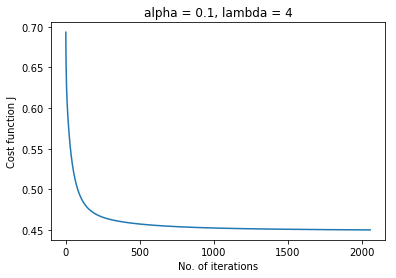

0.1	 4	 0:


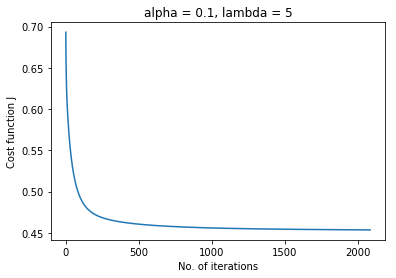

0.1	 5	 0:


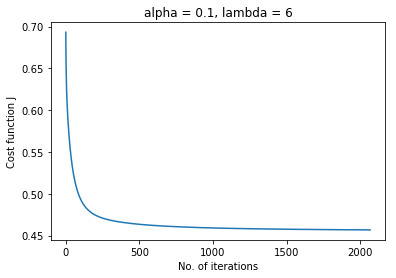

0.1	 6	 0:


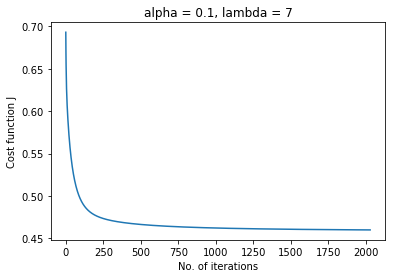

0.1	 7	 0:


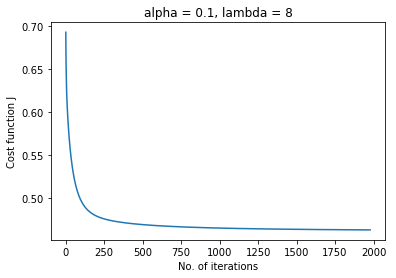

0.1	 8	 0:


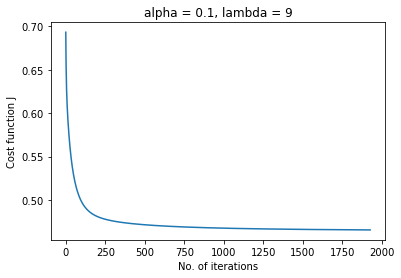

0.1	 9	 0:


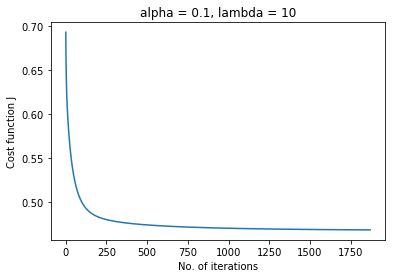

0.1	 10	 0:


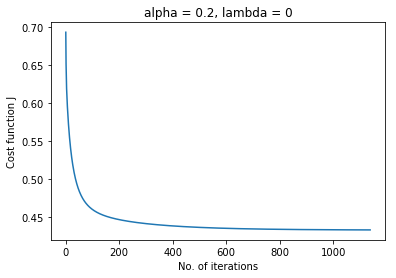

0.2	 0	 0:


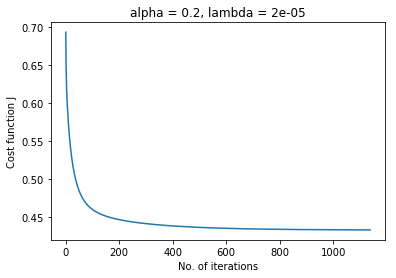

0.2	 2e-05	 0:


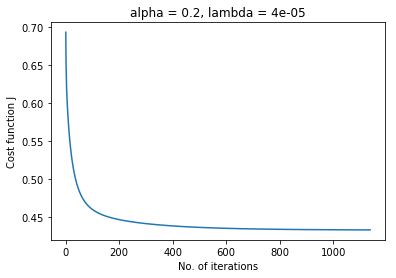

0.2	 4e-05	 0:


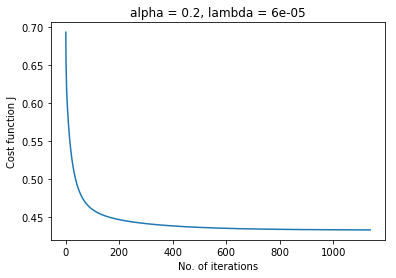

0.2	 6e-05	 0:


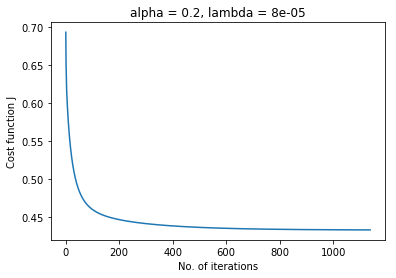

0.2	 8e-05	 0:


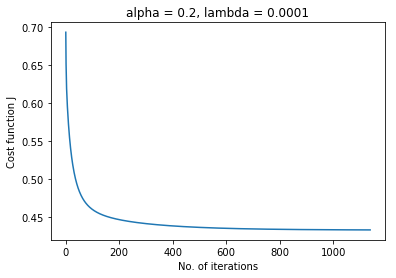

0.2	 0.0001	 0:


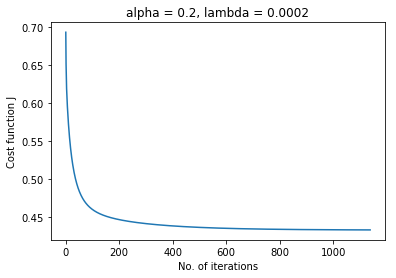

0.2	 0.0002	 0:


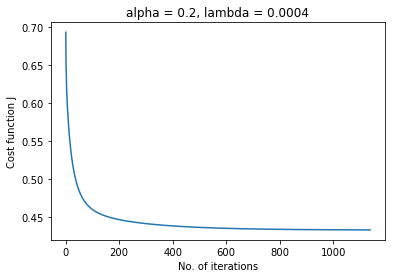

0.2	 0.0004	 0:


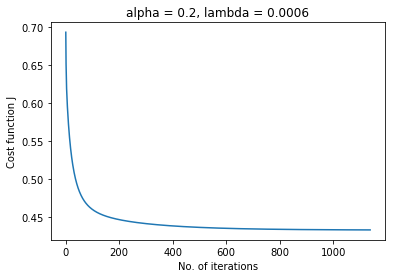

0.2	 0.0006	 0:


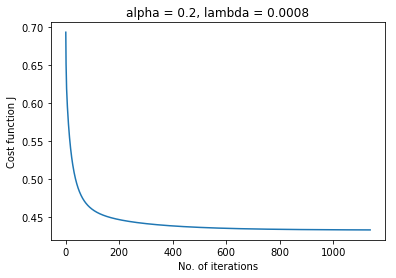

0.2	 0.0008	 0:


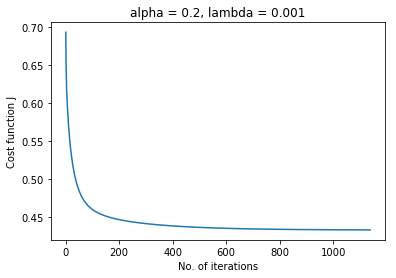

0.2	 0.001	 0:


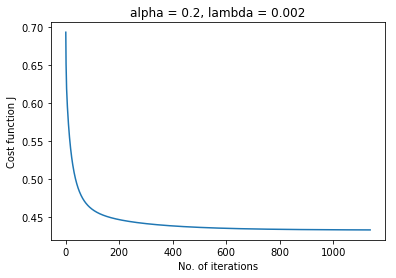

0.2	 0.002	 0:


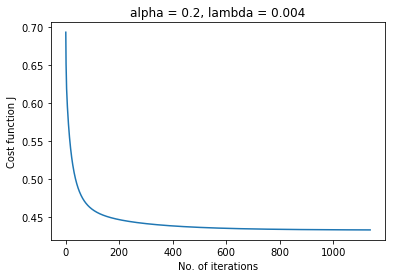

0.2	 0.004	 0:


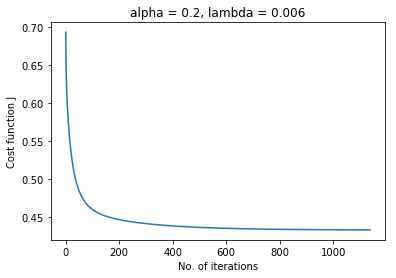

0.2	 0.006	 0:


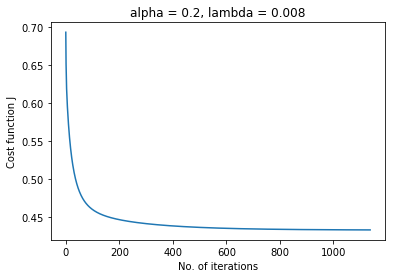

0.2	 0.008	 0:


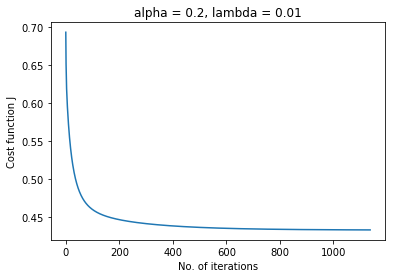

0.2	 0.01	 0:


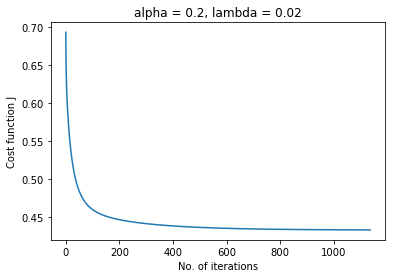

0.2	 0.02	 0:


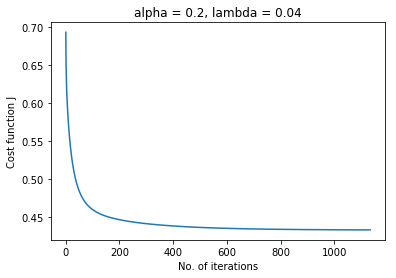

0.2	 0.04	 0:


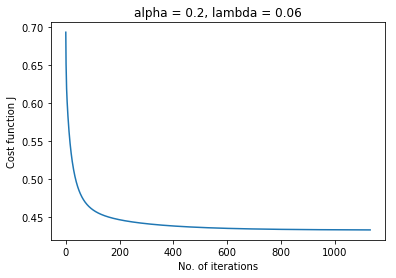

0.2	 0.06	 0:


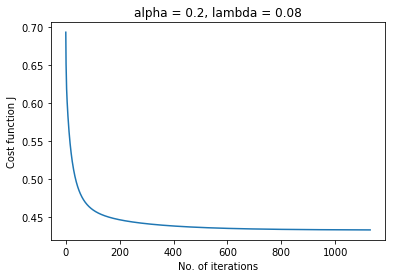

0.2	 0.08	 0:


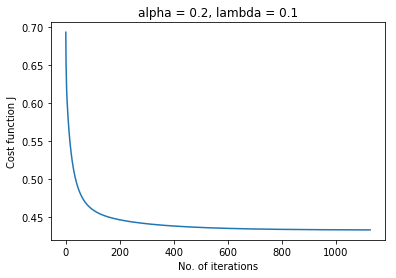

0.2	 0.1	 0:


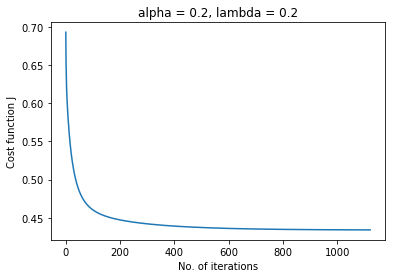

0.2	 0.2	 0:


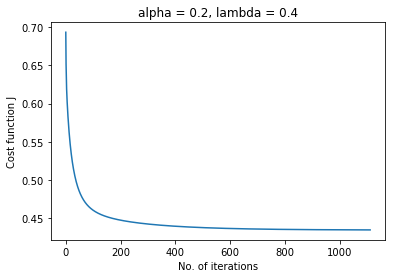

0.2	 0.4	 0:


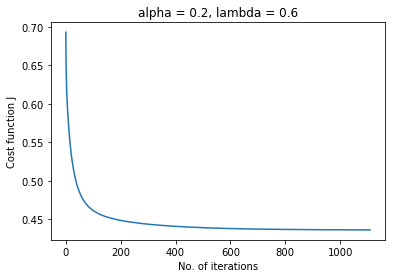

0.2	 0.6	 0:


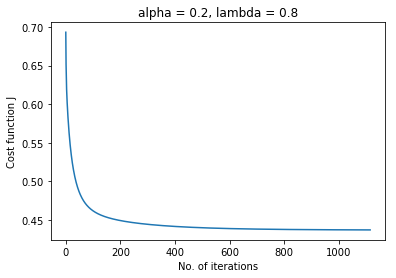

0.2	 0.8	 0:


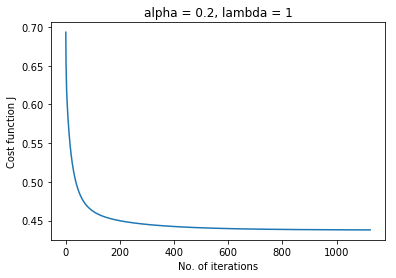

0.2	 1	 0:


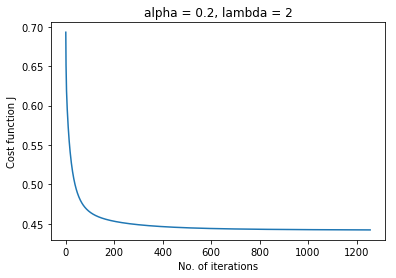

0.2	 2	 0:


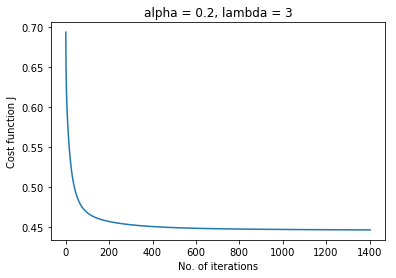

0.2	 3	 0:


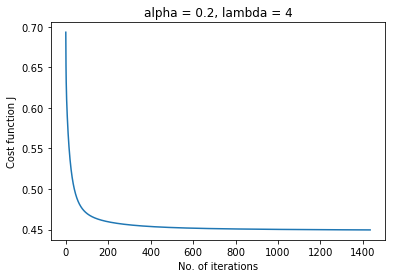

0.2	 4	 0:


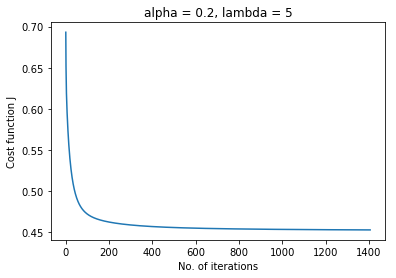

0.2	 5	 0:


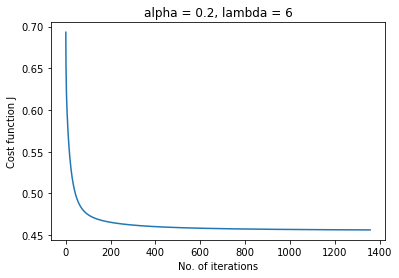

0.2	 6	 0:


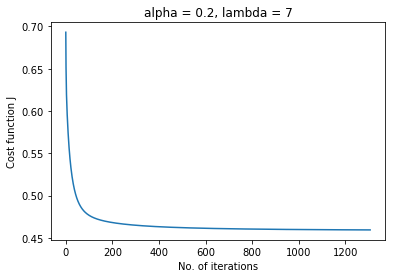

0.2	 7	 0:


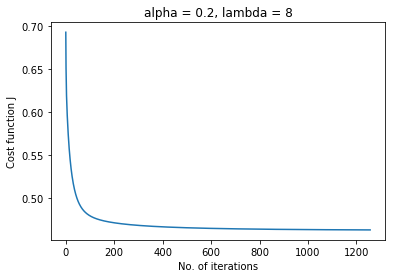

0.2	 8	 0:


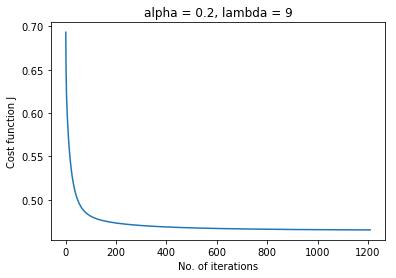

0.2	 9	 0:


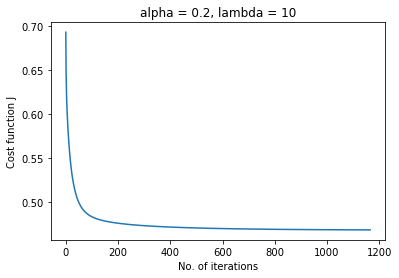

0.2	 10	 0:


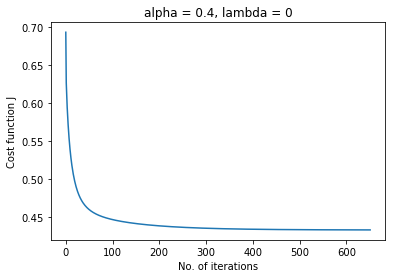

0.4	 0	 0:


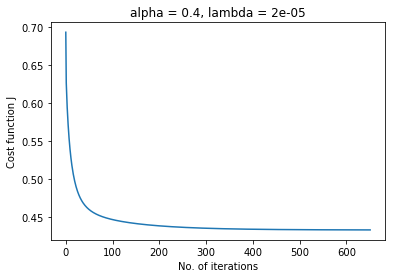

0.4	 2e-05	 0:


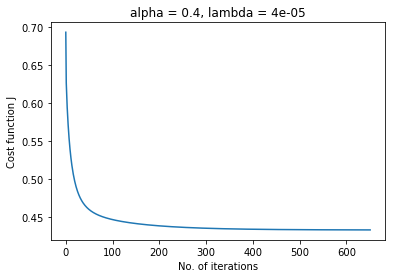

0.4	 4e-05	 0:


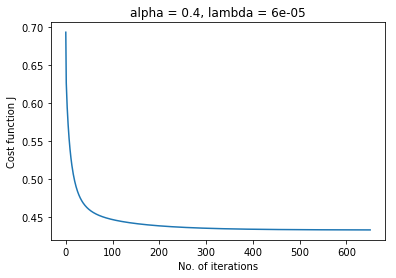

0.4	 6e-05	 0:


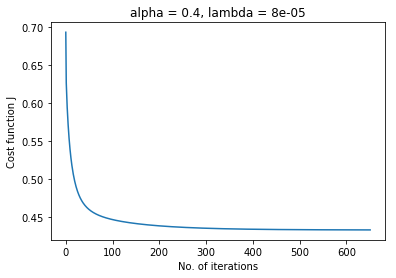

0.4	 8e-05	 0:


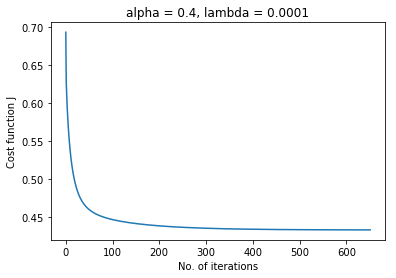

0.4	 0.0001	 0:


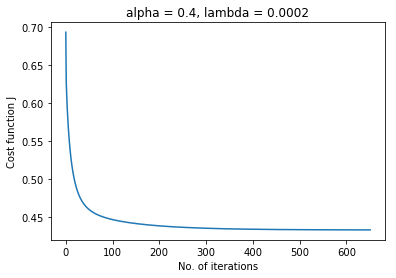

0.4	 0.0002	 0:


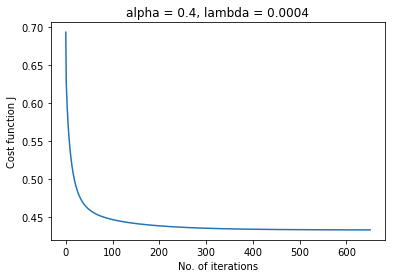

0.4	 0.0004	 0:


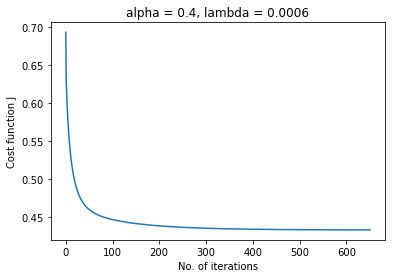

0.4	 0.0006	 0:


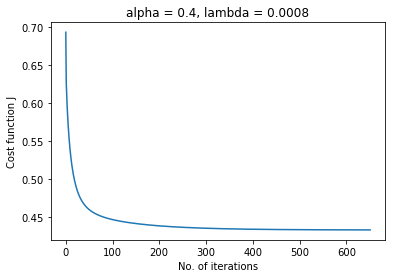

0.4	 0.0008	 0:


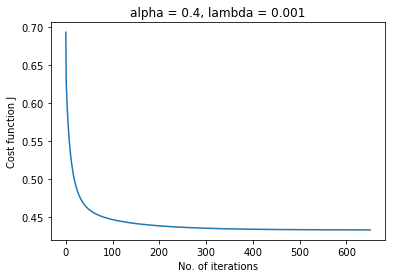

0.4	 0.001	 0:


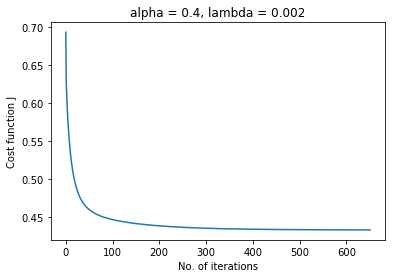

0.4	 0.002	 0:


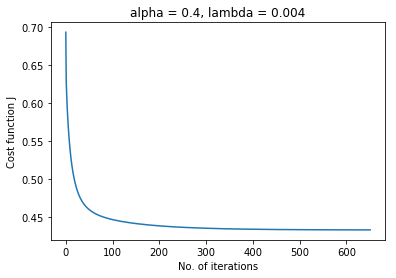

0.4	 0.004	 0:


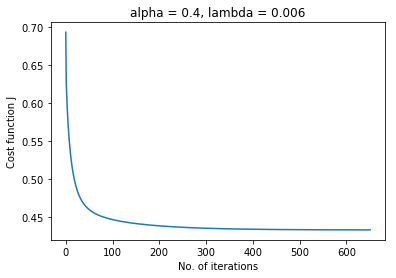

0.4	 0.006	 0:


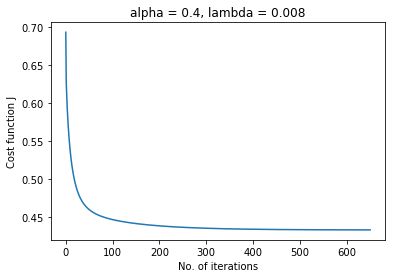

0.4	 0.008	 0:


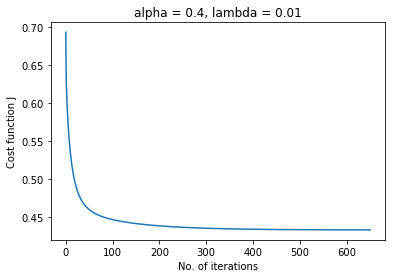

0.4	 0.01	 0:


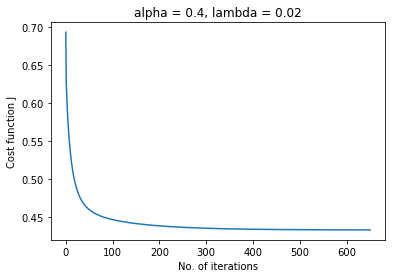

0.4	 0.02	 0:


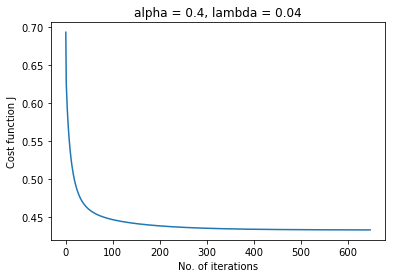

0.4	 0.04	 0:


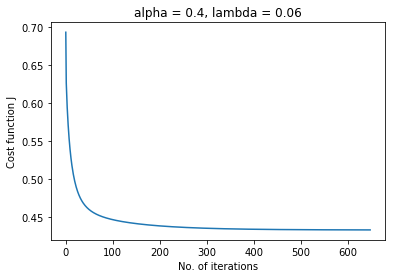

0.4	 0.06	 0:


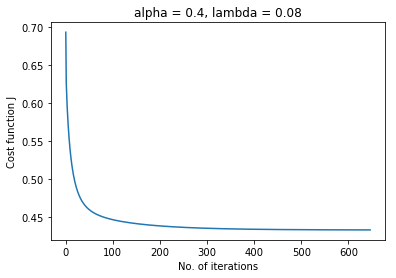

0.4	 0.08	 0:


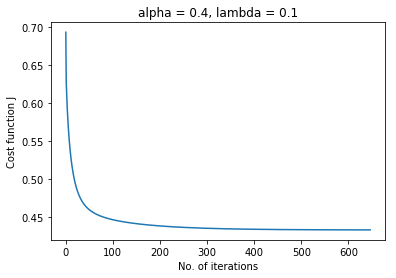

0.4	 0.1	 0:


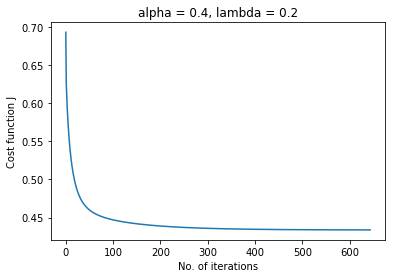

0.4	 0.2	 0:


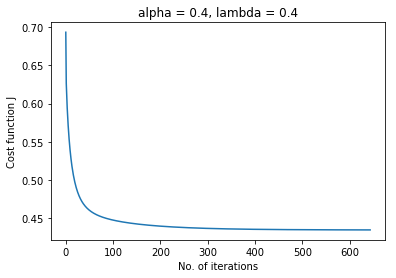

0.4	 0.4	 0:


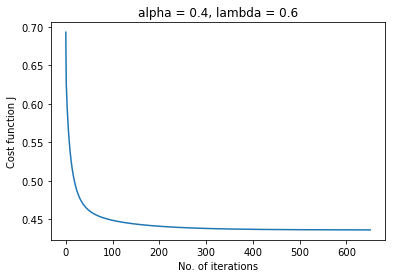

0.4	 0.6	 0:


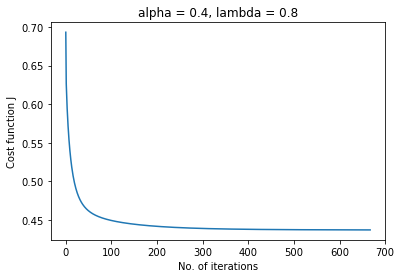

0.4	 0.8	 0:


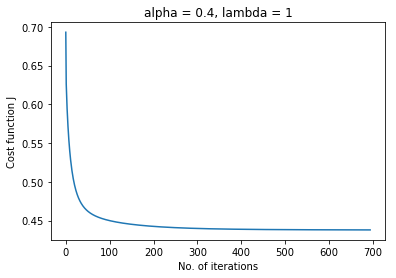

0.4	 1	 0:


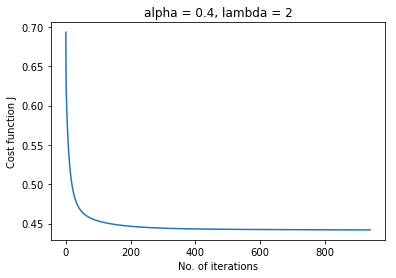

0.4	 2	 0:


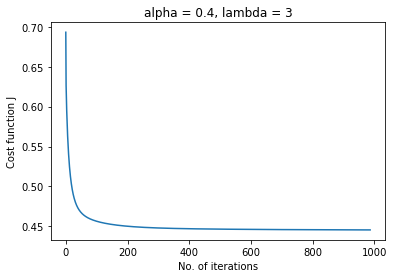

0.4	 3	 0:


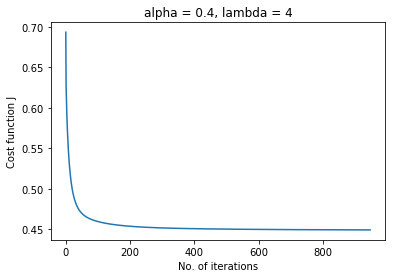

0.4	 4	 0:


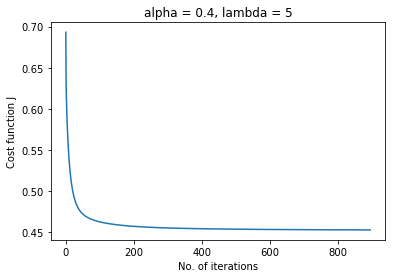

0.4	 5	 0:


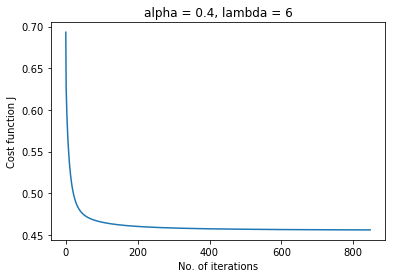

0.4	 6	 0:


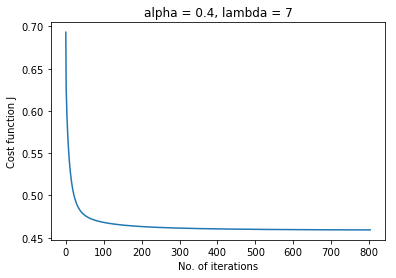

0.4	 7	 0:


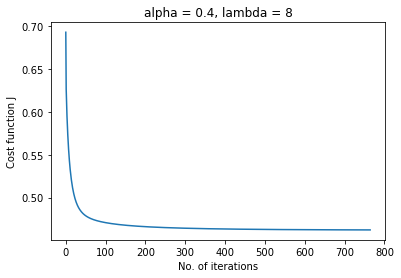

0.4	 8	 0:


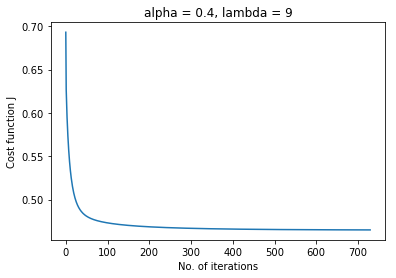

0.4	 9	 0:


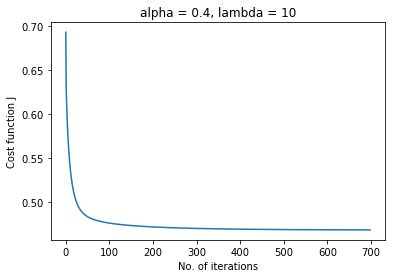

0.4	 10	 0:


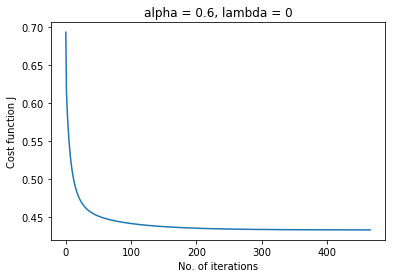

0.6	 0	 0:


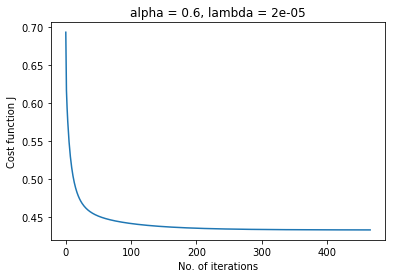

0.6	 2e-05	 0:


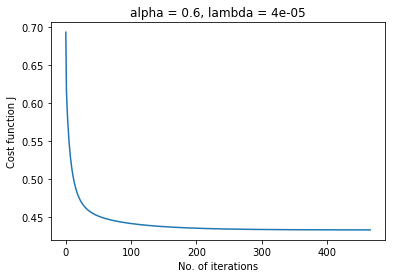

0.6	 4e-05	 0:


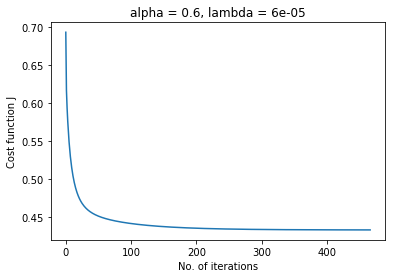

0.6	 6e-05	 0:


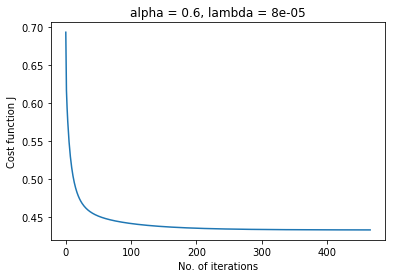

0.6	 8e-05	 0:


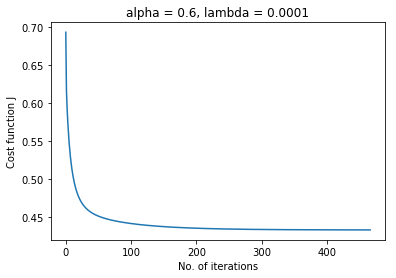

0.6	 0.0001	 0:


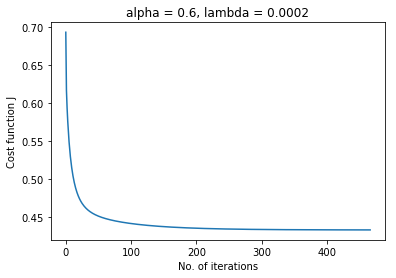

0.6	 0.0002	 0:


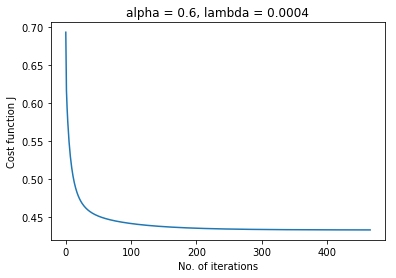

0.6	 0.0004	 0:


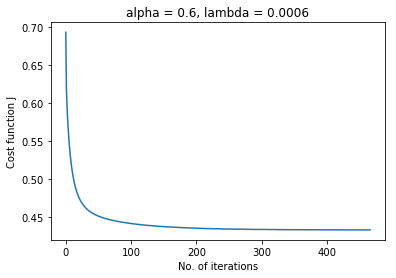

0.6	 0.0006	 0:


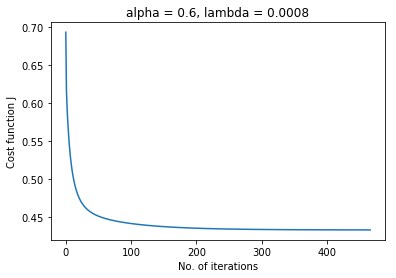

0.6	 0.0008	 0:


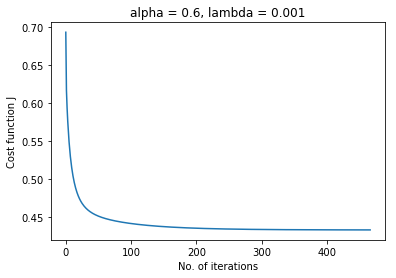

0.6	 0.001	 0:


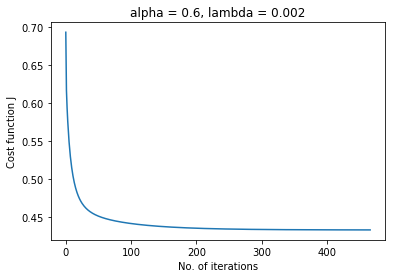

0.6	 0.002	 0:


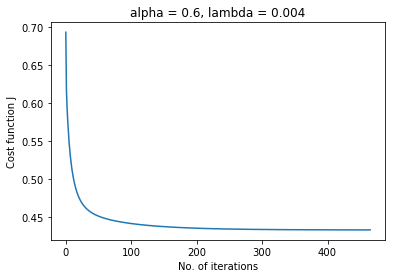

0.6	 0.004	 0:


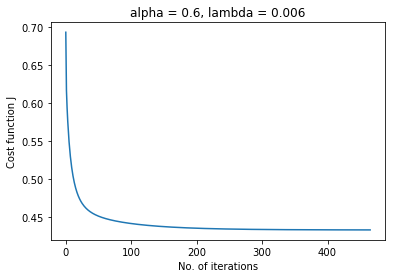

0.6	 0.006	 0:


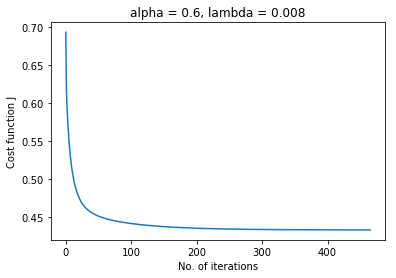

0.6	 0.008	 0:


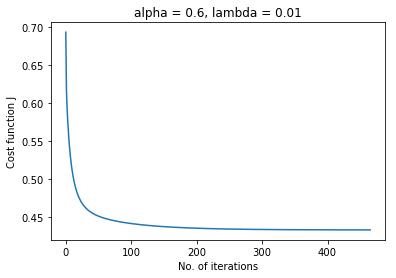

0.6	 0.01	 0:


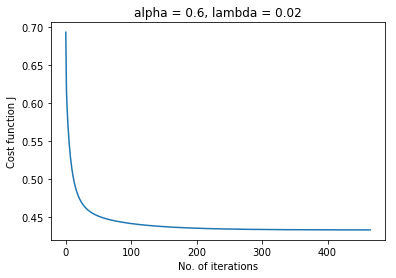

0.6	 0.02	 0:


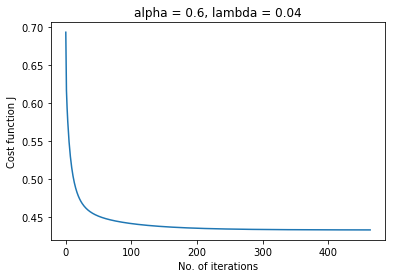

0.6	 0.04	 0:


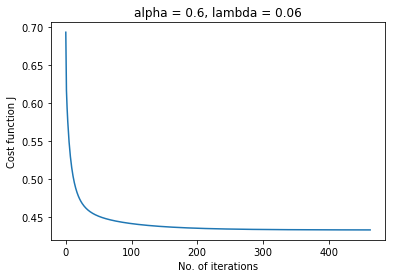

0.6	 0.06	 0:


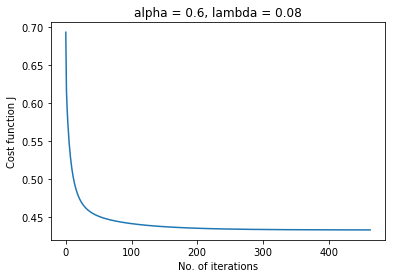

0.6	 0.08	 0:


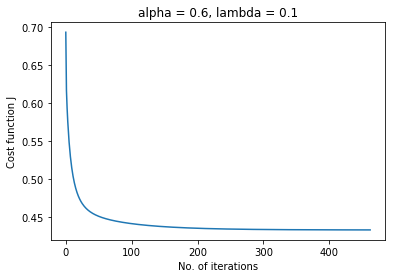

0.6	 0.1	 0:


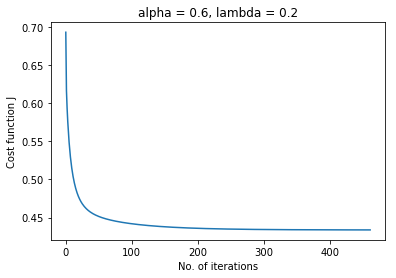

0.6	 0.2	 0:


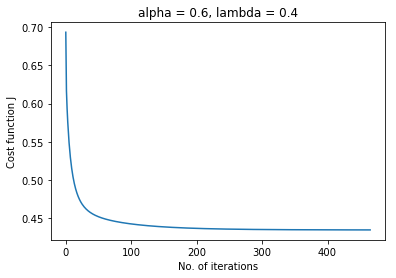

0.6	 0.4	 0:


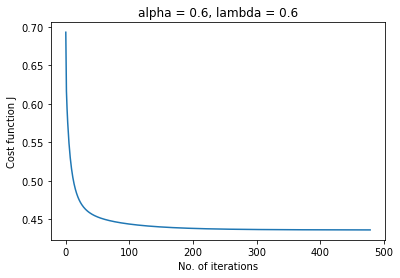

0.6	 0.6	 0:


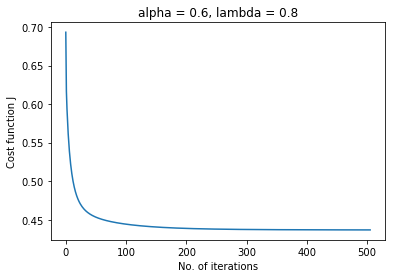

0.6	 0.8	 0:


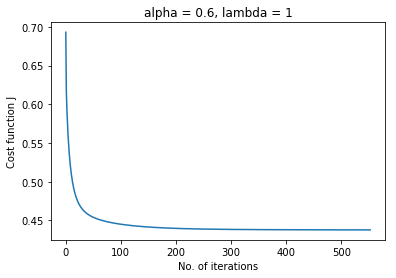

0.6	 1	 0:


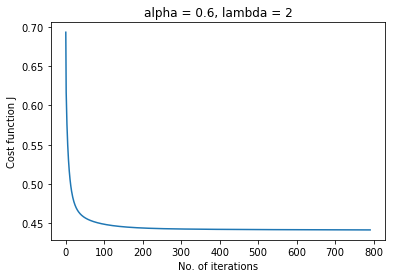

0.6	 2	 0:


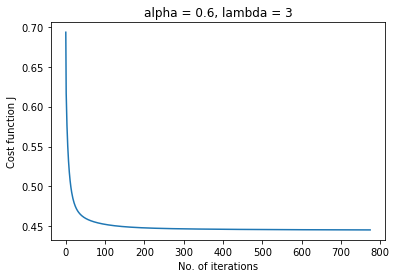

0.6	 3	 0:


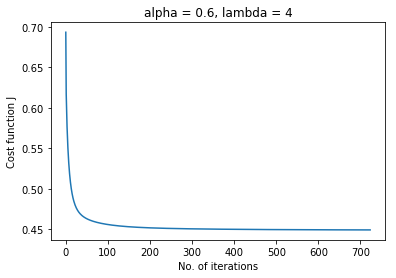

0.6	 4	 0:


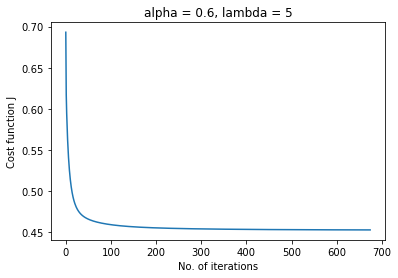

0.6	 5	 0:


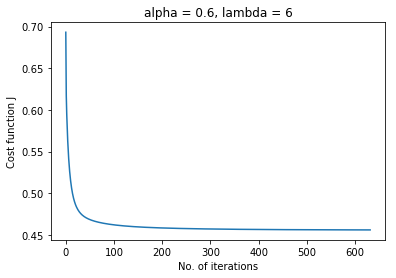

0.6	 6	 0:


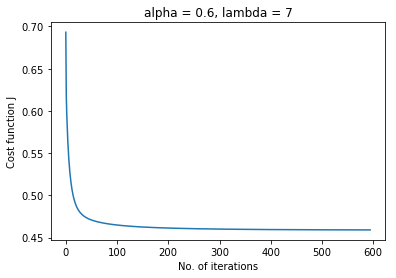

0.6	 7	 0:


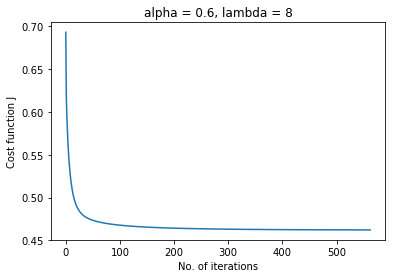

0.6	 8	 0:


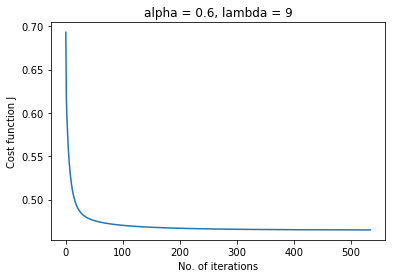

0.6	 9	 0:


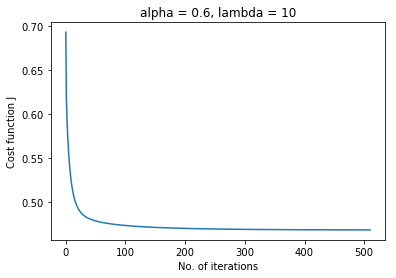

0.6	 10	 0:


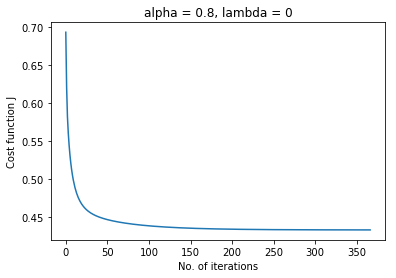

0.8	 0	 0:


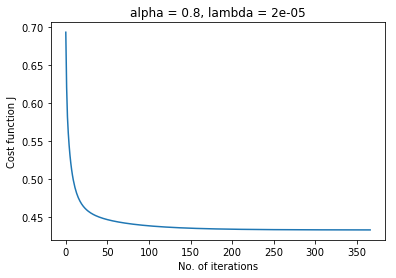

0.8	 2e-05	 0:


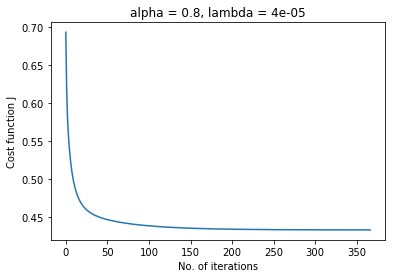

0.8	 4e-05	 0:


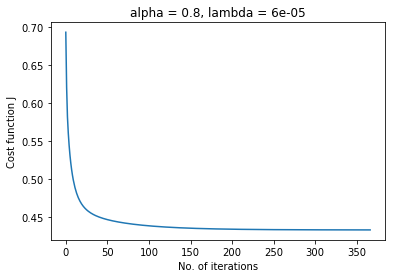

0.8	 6e-05	 0:


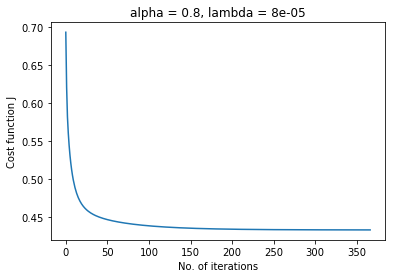

0.8	 8e-05	 0:


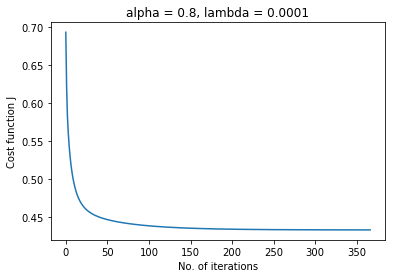

0.8	 0.0001	 0:


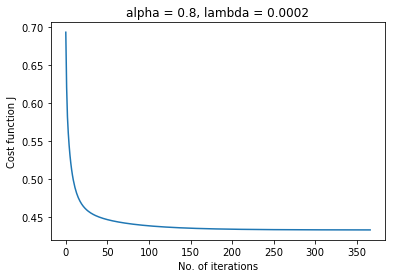

0.8	 0.0002	 0:


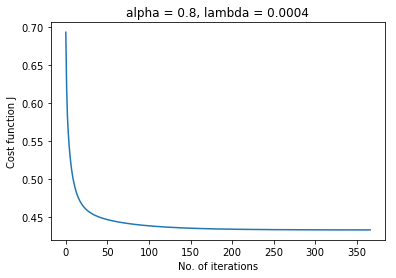

0.8	 0.0004	 0:


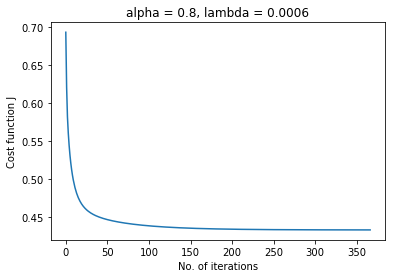

0.8	 0.0006	 0:


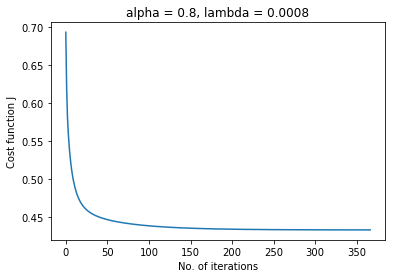

0.8	 0.0008	 0:


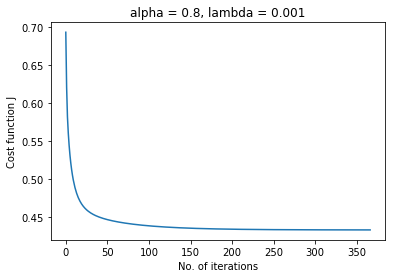

0.8	 0.001	 0:


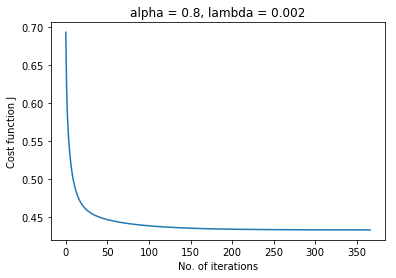

0.8	 0.002	 0:


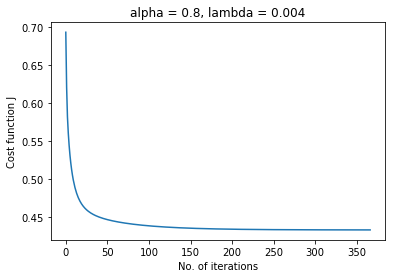

0.8	 0.004	 0:


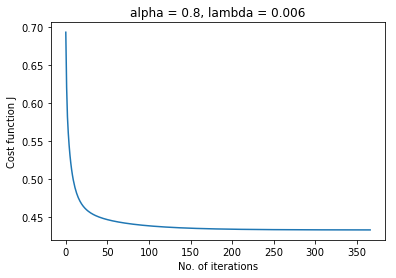

0.8	 0.006	 0:


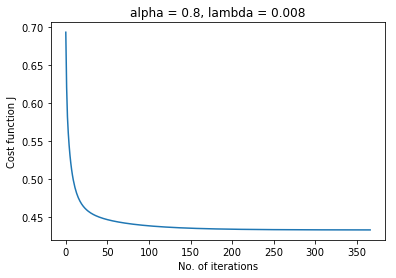

0.8	 0.008	 0:


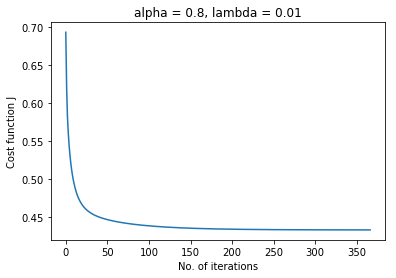

0.8	 0.01	 0:


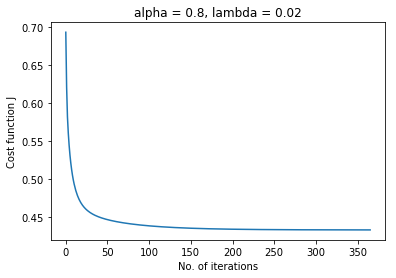

0.8	 0.02	 0:


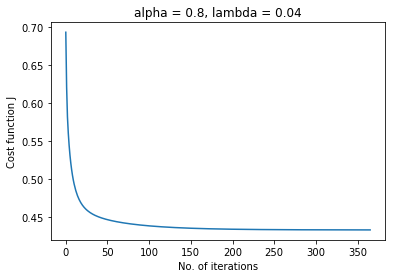

0.8	 0.04	 0:


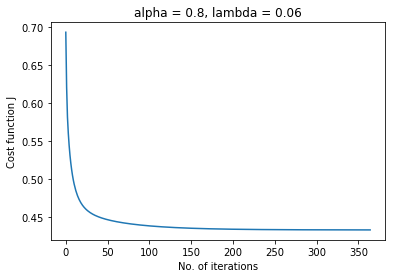

0.8	 0.06	 0:


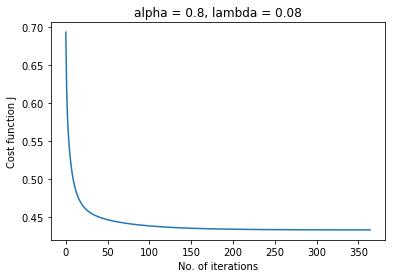

0.8	 0.08	 0:


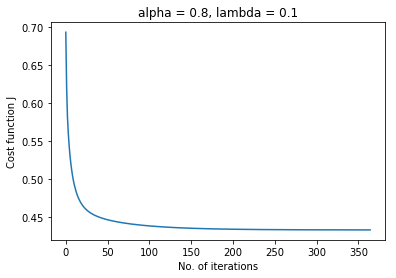

0.8	 0.1	 0:


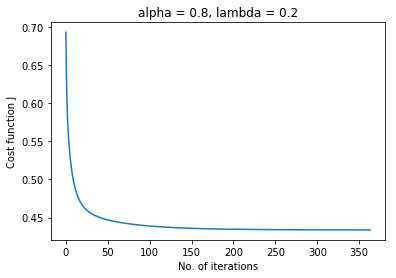

0.8	 0.2	 0:


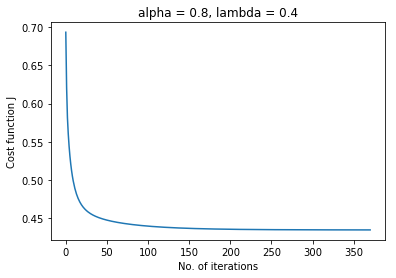

0.8	 0.4	 0:


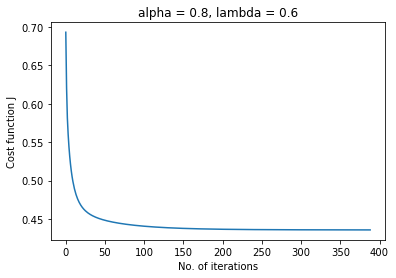

0.8	 0.6	 0:


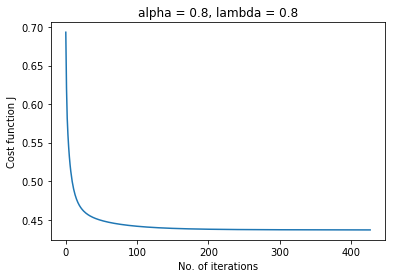

0.8	 0.8	 0:


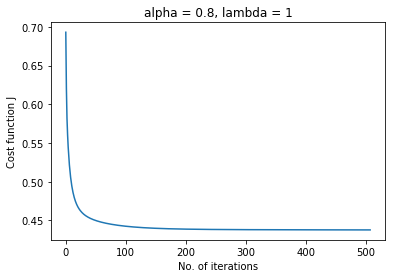

0.8	 1	 0:


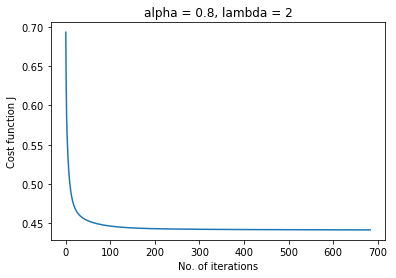

0.8	 2	 0:


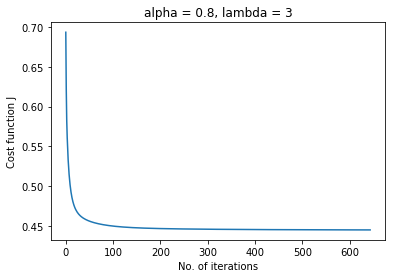

0.8	 3	 0:


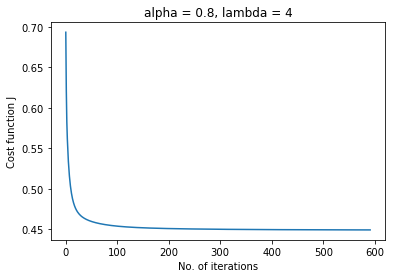

0.8	 4	 0:


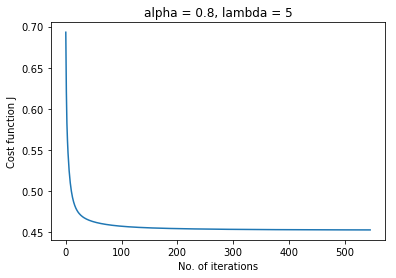

0.8	 5	 0:


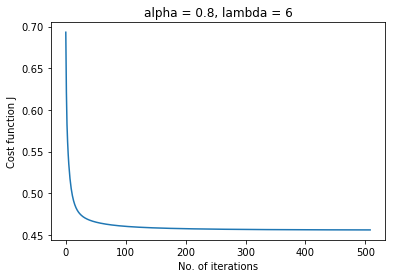

0.8	 6	 0:


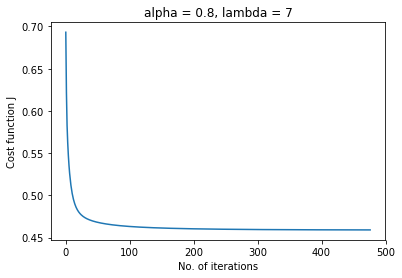

0.8	 7	 0:


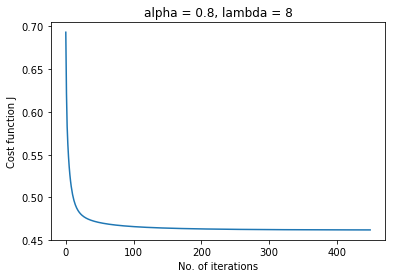

0.8	 8	 0:


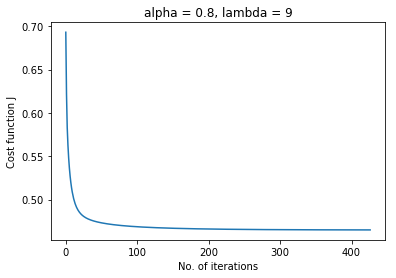

0.8	 9	 0:


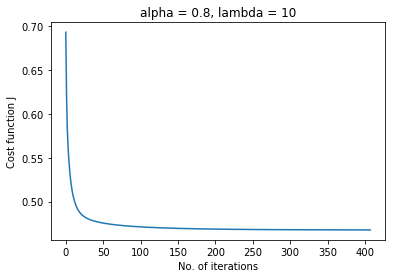

0.8	 10	 0:


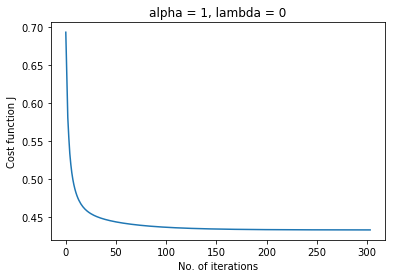

1	 0	 0:


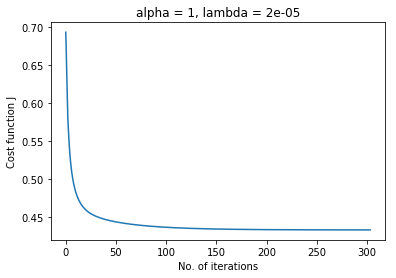

1	 2e-05	 0:


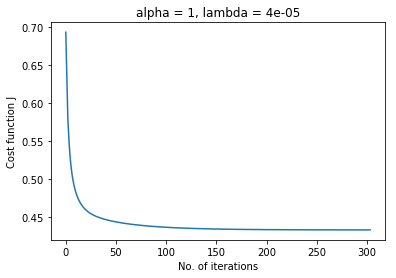

1	 4e-05	 0:


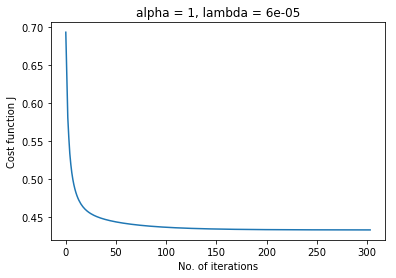

1	 6e-05	 0:


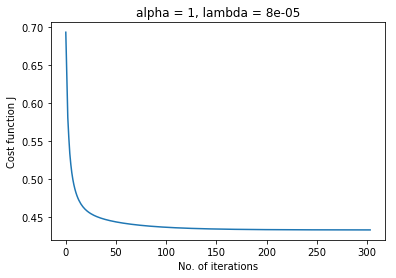

1	 8e-05	 0:


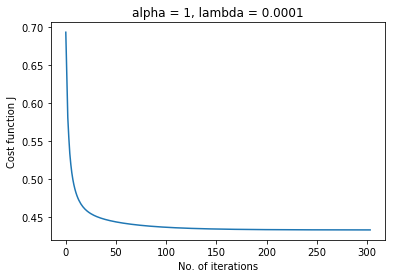

1	 0.0001	 0:


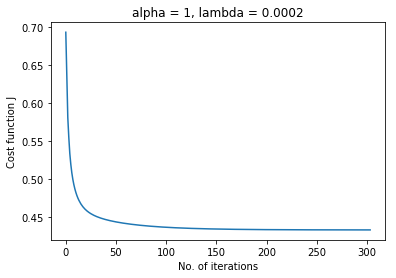

1	 0.0002	 0:


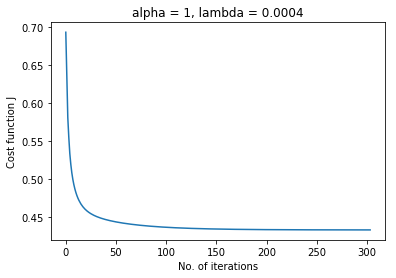

1	 0.0004	 0:


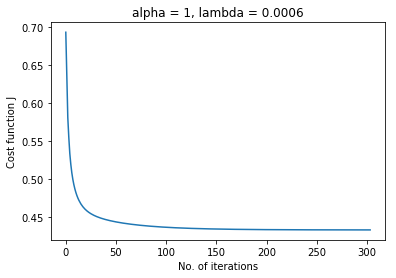

1	 0.0006	 0:


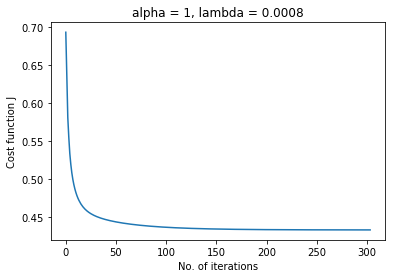

1	 0.0008	 0:


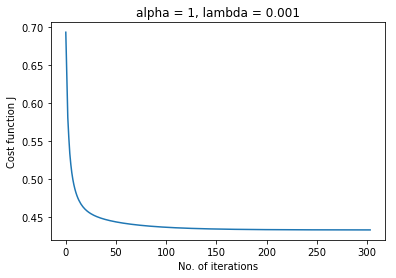

1	 0.001	 0:


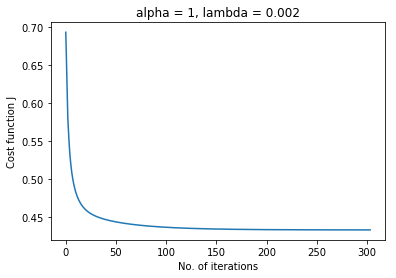

1	 0.002	 0:


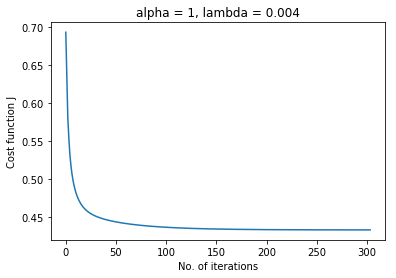

1	 0.004	 0:


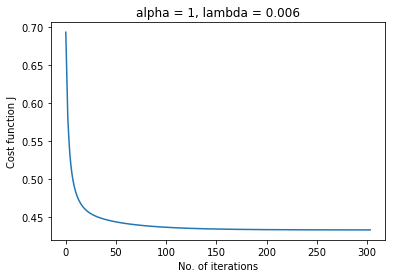

1	 0.006	 0:


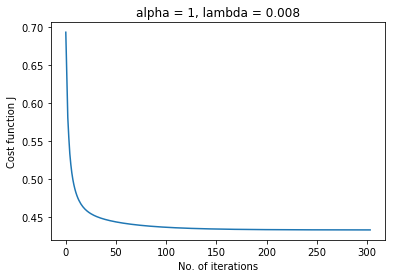

1	 0.008	 0:


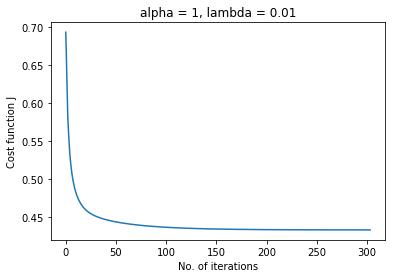

1	 0.01	 0:


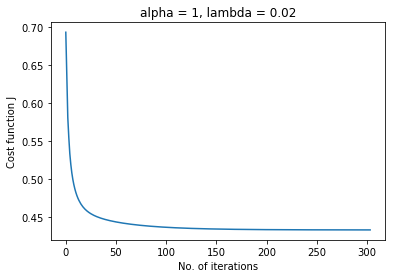

1	 0.02	 0:


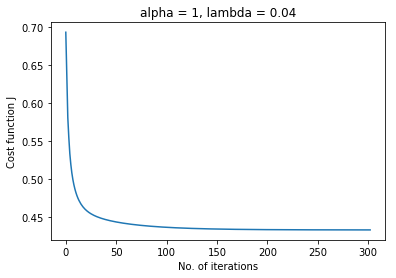

1	 0.04	 0:


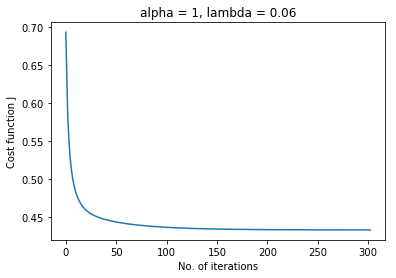

1	 0.06	 0:


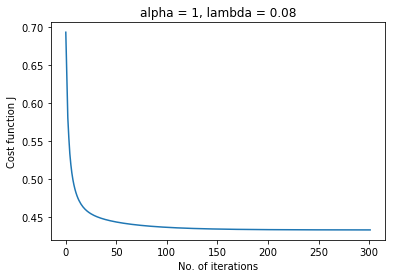

1	 0.08	 0:


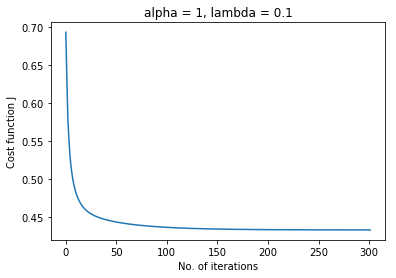

1	 0.1	 0:


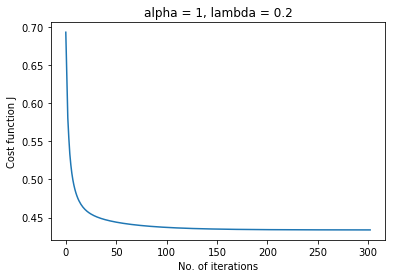

1	 0.2	 0:


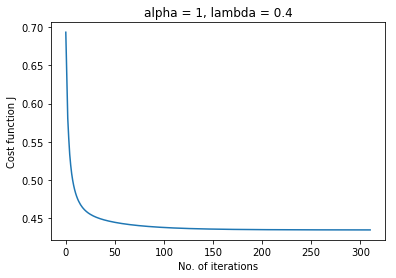

1	 0.4	 0:


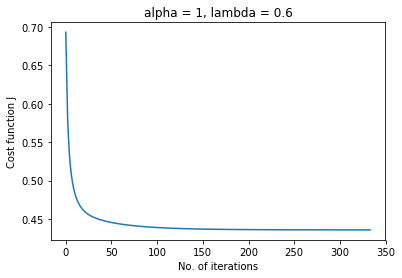

1	 0.6	 0:


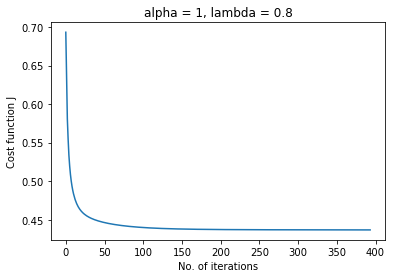

1	 0.8	 0:


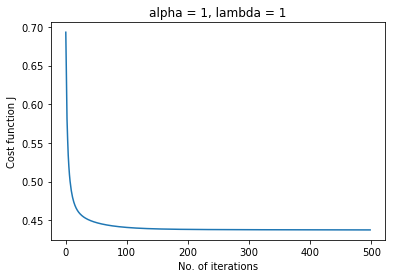

1	 1	 0:


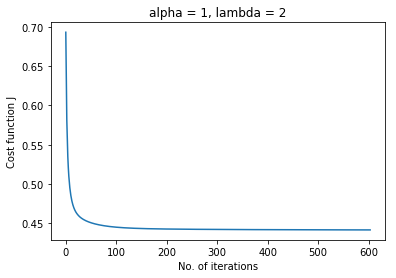

1	 2	 0:


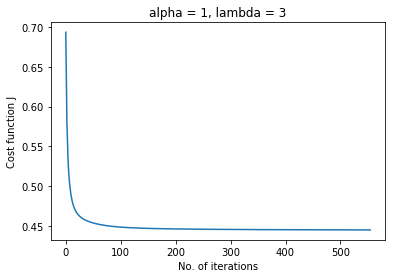

1	 3	 0:


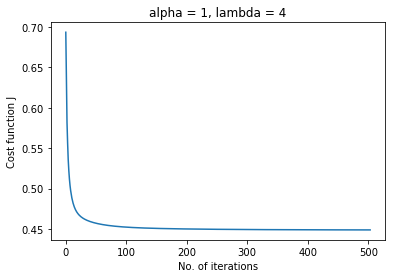

1	 4	 0:


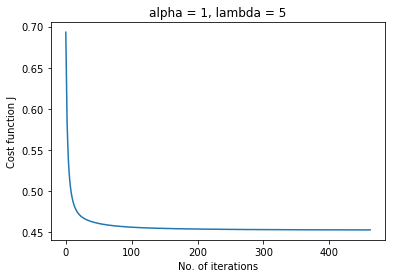

1	 5	 0:


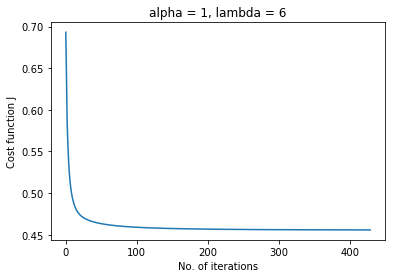

1	 6	 0:


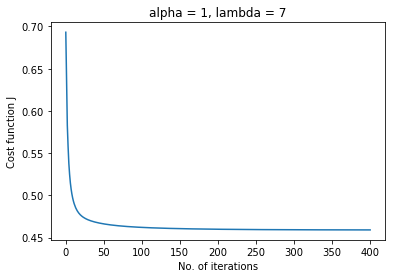

1	 7	 0:


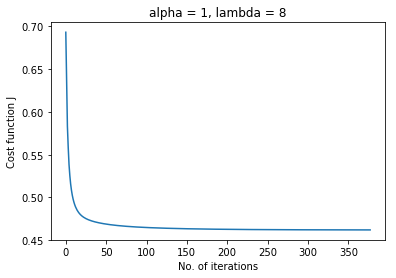

1	 8	 0:


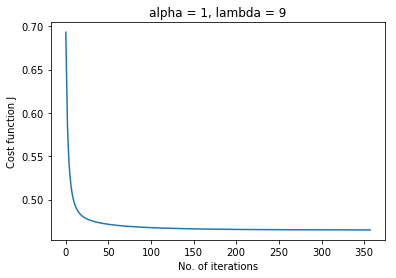

1	 9	 0:


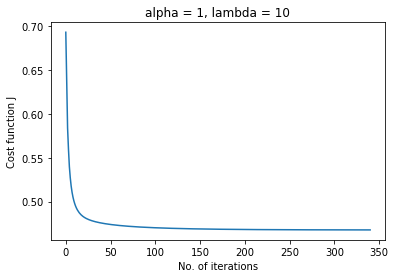

1	 10	 0:


In [1681]:
alphas = [0.001, 0.003, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
lambdas = [0, 0.00002, 0.00004, 0.00006, 0.00008, 0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[alpha_best, lambda_best, theta_best] = f1_score(X_train, X_cv, Y_train, Y_cv, lambdas, alphas)

In [1682]:
print 'best alpha = %r, lambda = %r' % (alpha_best, lambda_best)

best alpha = 0.001, lambda = 0


In [1683]:
print 'predict result by logistic regression:'
y_predict_lr = logistic_regression_predict(theta_best, X_test)
# y_predict_lr = [1 if p > 0.5 else 0 for p in y_predict_lr]
print len(test_id), len(y_predict_lr)
output_lr = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict_lr})
# output_lr.to_csv('Titanic_lr.csv', index=False)
output_lr.head()

predict result:
418 418


PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

# Xgboost

In [22]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'rmse',
    'silent': 0
}

In [27]:
dtrain = xgb.DMatrix(X_train, Y_train)
dcv = xgb.DMatrix(X_cv)
dtest = xgb.DMatrix(X_test)
xgboost_model = xgb.train(dict(xgb_params), dtrain, num_boost_round=1000)

In [29]:
print 'predict result by xgboost:'
y_predict_xgb = xgboost_model.predict(dtest)
# y_predict_xgb = [1 if p > 0.5 else 0 for p in y_predict_xgb]
print len(test_id), len(y_predict_xgb)
output_xgb = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict_xgb})
# output_xgb.to_csv('Titanic_xgb.csv', index=False)
output_xgb.head()

 predict result by xgboost:
418 418


PassengerId  Survived
0          892  0.006150
1          893  0.025330
2          894  0.183658
3          895  0.656750
4          896  0.398406

# Ensemble of the two models

In [ ]:
y_cv_lr = logistic_regression_predict(theta_best, X_cv)
y_cv_xgb = xgboost_model.predict(dtest)

In [ ]:
def f1_score(Y_cv_predict, Y_cv):
    tp = np.dot(y_cv_predict, Y_cv)
    fp = np.dot(y_cv_predict, 1 - Y_cv)
    fn = np.dot(1 - np.array(y_cv_predict), Y_cv)

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    F1 = 2*precision*recall/(precision + recall)
    
    return F1

In [ ]:
w1 = f1_score(y_cv_lr, Y_cv)
w2 = f1_score(y_cv_xgb, Y_cv)
w1 = w1 / (w1 + w2)
w2 = 1 - w1
y_predict = w1 * y_predict_lr + w2 * y_predict_xgb
y_predict = [1 if p > 0.5 else 0 for p in y_predict]
output = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
output.to_csv('Titanic.csv', index=False)
output.head()